### Author: [Pratik Sharma](https://github.com/sharmapratik88/)
# Project 5 - Feature Engineering Techniques

**Data Description**: The actual concrete compressive strength (MPa) for a given mixture under a specific age (days) was determined from laboratory. Data is in raw form (not scaled).The data has 8 quantitative input variables, and 1 quantitative output variable, and 1030 instances (observations).

**Domain**: Material manufacturing

**Context**: Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. These ingredients include cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate, and fine aggregate.

**Attribute Information**
	slag	ash	water	superplastic	coarseagg	fineagg	age	strength
* **`cement`**: measured in kg in a m3 mixture
* **`slag`**: measured in kg in a m3 mixture
* **`ash`**: measured in kg in a m3 mixture
* **`water`**: measured in kg in a m3 mixture
* **`superplastic`**: measured in kg in a m3 mixture
* **`coarseagg`**: measured in kg in a m3 mixture
* **`fineagg`**: measured in kg in a m3 mixture
* **`age`**: day (1~365)
* **`strength`**: Concrete compressive strength measured in MPa

**Learning Outcomes**
* Exploratory Data Analysis
* Building ML models for regression
* Hyper parameter tuning

In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Setting the current working directory
import os; os.chdir('drive/My Drive/Great Learning')

In [3]:
!pip install catboost
!pip install eli5

### Import Packages

In [1]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats; from scipy.stats import zscore, norm, randint
import matplotlib.style as style; style.use('fivethirtyeight')
from collections import OrderedDict
%matplotlib inline

# Checking Leverage and Influence Points
from statsmodels.graphics.regressionplots import *
import statsmodels.stats.stattools as stools
import statsmodels.formula.api as smf
import statsmodels.stats as stats
import scipy.stats as scipystats
import statsmodels.api as sm

# Checking multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# Cluster analysis
from sklearn.cluster import KMeans

# Feature importance
import eli5
from eli5.sklearn import PermutationImportance

# Modelling
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.svm import SVR
import xgboost as xgb

# Metrics
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Hyperparameter tuning
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.utils import resample

# Display settings
pd.options.display.max_rows = 400
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format

random_state = 2019
np.random.seed(random_state)

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'eli5'

In [5]:
# Checking if GPU is found
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


<a id='read'></a>
### Read the dataset and check first five rows

In [2]:
# Reading the data as dataframe and print the first five rows
concrete = pd.read_csv('concrete (1).csv')
concrete.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0   28   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7   28   

   strength  
0     29.89  
1     23.51  
2     29.22  
3     45.85  
4     18.29

<a id='EDA'></a>
## Exploratory Data Analysis
Performing exploratory data analysis on the cement dataset. Below are some of the steps performed:

* Univariate analysis – explore data types and description of the independent attributes including name, meaning, range of values observed, central values (mean and median), standard deviation and quartiles, analysis of the body of distributions / tails, missing values, outliers
* Bi-variate analysis between the predictor variables and between the predictor variables and target column. Comment findings in terms of their relationship and degree of relation if any. Visualize the analysis using boxplots and pair plots, histograms or density curves.

In [3]:
print('Several helper function that I created to help in EDA and Modelling'); print('--'*60)

# Customized describe function
def custom_describe(df):
  results = []
  for col in df.select_dtypes(include = ['float64', 'int64']).columns.tolist():
    stats = OrderedDict({'': col, 'Count': df[col].count(), 'Type': df[col].dtype, 'Mean': round(df[col].mean(), 2), 'StandardDeviation': round(df[col].std(), 2), 
                         'Variance': round(df[col].var(), 2), 'Minimum': round(df[col].min(), 2), 'Q1': round(df[col].quantile(0.25), 2), 
                         'Median': round(df[col].median(), 2), 'Q3': round(df[col].quantile(0.75), 2), 'Maximum': round(df[col].max(), 2),
                         'Range': round(df[col].max(), 2)-round(df[col].min(), 2), 'IQR': round(df[col].quantile(0.75), 2)-round(df[col].quantile(0.25), 2),
                         'Kurtosis': round(df[col].kurt(), 2), 'Skewness': round(df[col].skew(), 2), 'MeanAbsoluteDeviation': round(df[col].mad(), 2)})
    if df[col].skew() < -1:
      if df[col].median() < df[col].mean():
        ske = 'Highly Skewed (Right)'
      else:
        ske = 'Highly Skewed (Left)'
    elif -1 <= df[col].skew() <= -0.5:
      if df[col].median() < df[col].mean():
        ske = 'Moderately Skewed (Right)'
      else:
        ske = 'Moderately Skewed (Left)'
    elif -0.5 < df[col].skew() <= 0:
      if df[col].median() < df[col].mean():
        ske = 'Fairly Symmetrical (Right)'
      else:
        ske = 'Fairly Symmetrical (Left)'
    elif 0 < df[col].skew() <= 0.5:
      if df[col].median() < df[col].mean():
        ske = 'Fairly Symmetrical (Right)'
      else:
        ske = 'Fairly Symmetrical (Left)'
    elif 0.5 < df[col].skew() <= 1:
      if df[col].median() < df[col].mean():
        ske = 'Moderately Skewed (Right)'
      else:
        ske = 'Moderately Skewed (Left)'
    elif df[col].skew() > 1:
      if df[col].median() < df[col].mean():
        ske = 'Highly Skewed (Right)'
      else:
        ske = 'Highly Skewed (Left)'
    else:
      ske = 'Error'
    stats['SkewnessComment'] = ske
    upper_lim, lower_lim = stats['Q3'] + (1.5 * stats['IQR']), stats['Q1'] - (1.5 * stats['IQR'])
    if len([x for x in df[col] if x < lower_lim or x > upper_lim])>1:
      out = 'HasOutliers'
    else:
      out = 'NoOutliers'
    stats['OutliersComment'] = out
    results.append(stats)
  statistics = pd.DataFrame(results).set_index('')

  return display(statistics)

# Functions that will help us with EDA plot
def odp_plots(df, col):
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))
    
    # Boxplot to check outliers
    sns.boxplot(x = col, data = df, ax = ax1, orient = 'v', color = 'darkslategrey')
    
    # Distribution plot with outliers
    sns.distplot(df[col], ax = ax2, color = 'teal', fit = norm, rug = True).set_title(f'{col} with outliers')
    ax2.axvline(df[col].mean(), color = 'r', linestyle = '--', label = 'Mean', linewidth = 1.2)
    ax2.axvline(df[col].median(), color = 'g', linestyle = '--', label = 'Median', linewidth = 1.2)
    ax2.axvline(df[col].mode()[0], color = 'b', linestyle = '--', label = 'Mode', linewidth = 1.2); ax2.legend(loc = 'best')
    
    # Removing outliers, but in a new dataframe
    upperbound, lowerbound = np.percentile(df[col], [1, 99])
    y = pd.DataFrame(np.clip(df[col], upperbound, lowerbound))
    
    # Distribution plot without outliers
    sns.distplot(y[col], ax = ax3, color = 'tab:orange', fit = norm, rug = True).set_title(f'{col} without outliers')
    ax3.axvline(y[col].mean(), color = 'r', linestyle = '--', label = 'Mean', linewidth = 1.2)
    ax3.axvline(y[col].median(), color = 'g', linestyle = '--', label = 'Median', linewidth = 1.2)
    ax3.axvline(y[col].mode()[0], color = 'b', linestyle = '--', label = 'Mode', linewidth = 1.2); ax3.legend(loc = 'best')
    
    kwargs = {'fontsize':14, 'color':'black'}
    ax1.set_title(col + ' Boxplot Analysis', **kwargs)
    ax1.set_xlabel('Box', **kwargs)
    ax1.set_ylabel(col + ' Values', **kwargs)

    return plt.show()

# Correlation matrix for all variables
def correlation_matrix(df, threshold = 0.8):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize = (15, 7.2))
    cmap = sns.diverging_palette(220, 10, as_cmap = True)
    sns.heatmap(corr, mask = mask, cmap = cmap, square = True, linewidths = .5, cbar_kws = {"shrink": .5})#, annot = True)
    ax.set_title('Correlation Matrix of Data')

    # Filter for correlation value greater than threshold
    sort = corr.abs().unstack()
    sort = sort.sort_values(kind = "quicksort", ascending = False)
    display(sort[(sort > threshold) & (sort < 1)])
    
# Outliers removal
def outliers(df, col, method = 'quantile', strategy = 'median', drop = True):
    if method == 'quantile':
        Q3, Q2, Q1 = df[col].quantile([0.75, 0.50, 0.25])
        IQR = Q3 - Q1
        upper_lim = Q3 + (1.5 * IQR)
        lower_lim = Q1 - (1.5 * IQR)
        print(f'Outliers for {col} are: {sorted([x for x in df[col] if x < lower_lim or x > upper_lim])}\n')
        if strategy == 'median':
            df.loc[(df[col] < lower_lim) | (df[col] > upper_lim), col] = Q2
        else:
            df.loc[(df[col] < lower_lim) | (df[col] > upper_lim), col] = df[col].mean()
    elif method == 'stddev':
        col_mean, col_std, Q2 = df[col].mean(), df[col].std(), df[col].median()
        cut_off = col_std * 3
        lower_lim, upper_lim = col_mean - cut_off, col_mean + cut_off
        print(f'Outliers for {col} are: {sorted([x for x in df[col] if x < lower_lim or x > upper_lim])}\n')
        if strategy == 'median':
            df.loc[(df[col] < lower_lim) | (df[col] > upper_lim), col] = Q2
        else:
            df.loc[(df[col] < lower_lim) | (df[col] > upper_lim), col] = col_mean
    else:
      print('Please pass the correct method, strategy or drop criteria')

# KMeans Plots
def kmeans_plots(df, compcol):
  columns = list(set(list(df.columns))-set([compcol]))
  f, ax = plt.subplots(4, 2, figsize = (15, 15))
  ax[0][0].scatter(X[compcol], X[columns[0]], c = labels, s = 25, cmap = 'viridis'); ax[0][0].set_xlabel(compcol); ax[0][0].set_ylabel(columns[0])
  ax[0][1].scatter(X[compcol], X[columns[1]], c = labels, s = 25, cmap = 'viridis'); ax[0][1].set_xlabel(compcol); ax[0][1].set_ylabel(columns[1])
  ax[1][0].scatter(X[compcol], X[columns[2]], c = labels, s = 25, cmap = 'viridis'); ax[1][0].set_xlabel(compcol); ax[1][0].set_ylabel(columns[2])
  ax[1][1].scatter(X[compcol], X[columns[3]], c = labels, s = 25, cmap = 'viridis'); ax[1][1].set_xlabel(compcol); ax[1][1].set_ylabel(columns[3])
  ax[2][0].scatter(X[compcol], X[columns[4]], c = labels, s = 25, cmap = 'viridis'); ax[2][0].set_xlabel(compcol); ax[2][0].set_ylabel(columns[4])
  ax[2][1].scatter(X[compcol], X[columns[5]], c = labels, s = 25, cmap = 'viridis'); ax[2][1].set_xlabel(compcol); ax[2][1].set_ylabel(columns[5])
  ax[3][0].scatter(X[compcol], X[columns[6]], c = labels, s = 25, cmap = 'viridis'); ax[3][0].set_xlabel(compcol); ax[3][0].set_ylabel(columns[5])

# For rmse scoring
def rmse_score(y, y_pred):
    return np.sqrt(np.mean((y_pred - y)**2))

# Function to get top results from grid search and randomized search
def report(results):
    df = pd.concat([pd.DataFrame(results.cv_results_['params']), pd.DataFrame(results.cv_results_['mean_test_score'], columns = ['r2'])], axis = 1)
    return df

Several helper function that I created to help in EDA and Modelling
------------------------------------------------------------------------------------------------------------------------


<a id='uni'></a>
### Univariate analysis

In [5]:
# Get info of the dataframe columns
concrete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [6]:
concrete.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

<a id='o1'></a>
#### Observation 1 - Dataset shape
Dataset has 1030 rows and 9 columns, with no missing values.

<a id='o2'></a>
#### Observation 2 - Information on the type of variable

All features are of numerical types. `strength` is a target variable (continuous). `age` is a discrete feature whereas rest of them are continuous.

In [10]:
### Five point summary of numerical attributes and check unique values in 'object' columns
print('Five point summary of the dataframe'); print('--'*60)

custom_describe(concrete)

Five point summary of the dataframe
------------------------------------------------------------------------------------------------------------------------


Count     Type   Mean  StandardDeviation  Variance  Minimum  \
                                                                            
cement         1030  float64 281.17             104.51  10921.58   102.00   
slag           1030  float64  73.90              86.28   7444.12     0.00   
ash            1030  float64  54.19              64.00   4095.62     0.00   
water          1030  float64 181.57              21.35    456.00   121.80   
superplastic   1030  float64   6.20               5.97     35.69     0.00   
coarseagg      1030  float64 972.92              77.75   6045.68   801.00   
fineagg        1030  float64 773.58              80.18   6428.19   594.00   
age            1030    int64  45.66              63.17   3990.44     1.00   
strength       1030  float64  35.82              16.71    279.08     2.33   

                 Q1  Median      Q3  Maximum  Range    IQR  Kurtosis  \
                                                                       
cement       192.38  272.90  350.00   540.00 438.00 157.62     -0.52   
slag           0.00   22.00  142.95   359.40 359.40 142.95     -0.51   
ash            0.00    0.00  118.30   200.10 200.10 118.30     -1.33   
water        164.90  185.00  192.00   247.00 125.20  27.10      0.12   
superplastic   0.00    6.40   10.20    32.20  32.20  10.20      1.41   
coarseagg    932.00  968.00 1029.40  1145.00 344.00  97.40     -0.60   
fineagg      730.95  779.50  824.00   992.60 398.60  93.05     -0.10   
age            7.00   28.00   56.00   365.00 364.00  49.00     12.17   
strength      23.71   34.45   46.14    82.60  80.27  22.43     -0.31   

              Skewness  MeanAbsoluteDeviation             SkewnessComment  \
                                                                            
cement            0.51                  86.78   Moderately Skewed (Right)   
slag              0.80                  76.93   Moderately Skewed (Right)   
ash               0.54                  60.42   Moderately Skewed (Right)   
water             0.07                  16.92   Fairly Symmetrical (Left)   
superplastic      0.91                   4.92    Moderately Skewed (Left)   
coarseagg        -0.04                  62.80  Fairly Symmetrical (Right)   
fineagg          -0.25                  61.88   Fairly Symmetrical (Left)   
age               3.27                  39.12       Highly Skewed (Right)   
strength          0.42                  13.46  Fairly Symmetrical (Right)   

             OutliersComment  
                              
cement            NoOutliers  
slag             HasOutliers  
ash               NoOutliers  
water            HasOutliers  
superplastic     HasOutliers  
coarseagg         NoOutliers  
fineagg          HasOutliers  
age              HasOutliers  
strength         HasOutliers

<a id='o3'></a>
#### Observation 3 - Descriptive statistics
* **`cement`**: Data ranges between 102 to 540, while 25th and 75th percentile is spread between 192.38 to 350. Median (272.90) is less than Mean (281.17) which means cement is moderately skewed to the right. Column has no outliers.
* **`slag`**: Data ranges between 0 to 359.40, while 25th and 75th percentile is spread between 0 to 142.95. Median (22) is less than Mean (73.90) which means slag is moderately skewed to the right. Column has outliers.
* **`ash`**: Data ranges between 0 to 200.10, while 25th and 75th percentile is spread between 0 to 118.30. Median (0) is less than Mean (54.19) which mean ash is moderately skewed to the right. Column has no outliers.
* **`water`**: Data ranges between 121.80 to 247, while 25th and 75th percentile is spread between 164.90 and 192. Median (185) is greater than Mean (181.57) which means water is skewed to the left (fairly sym). Column has outliers.
* **`superplastic`**: Data ranges between 0 to 32.20, while 25th and 75th percentile is spread between 0 to 10.20. Median (6.40) is greater than Mean (6.20) which means superplastic is moderately skewed to the left. Column has outliers.
* **`coarseagg`**: Data ranges between 801 to 1145, while 25th and 75th percentile is spread between 932 to 1029.40. Median (968) is less than Mean (972.92) which means coarseagg is skewed to the right (fairly sym). Column has no outliers.
* **`fineagg`**: Data ranges between 594 to 992.60, while 25th and 75th percentile is spread between 730.95 to 824. Median (779.5) is greater than Mean (773.58) which means fineagg is skewed to the left (fairly sym). Column has no outliers.
* **`age`**: Data ranges between 1 to 365, while 25th and 75th percentile is spread between 7 to 56. Median (28) is less than Mean (45.66) which means age is highly skewed to the right. Column has no outliers.
* **`strength`**: Data ranges between 2.33 to 82.60, while 25th and 75th percentile is spread between 23.71 to 46.14. Median (34.45) is less than Mean (35.82) which means strength is slightly skewed to the right (fairly sym). Column has no outliers.

A quick check to find columns that contain outliers, graphical
------------------------------------------------------------------------------------------------------------------------


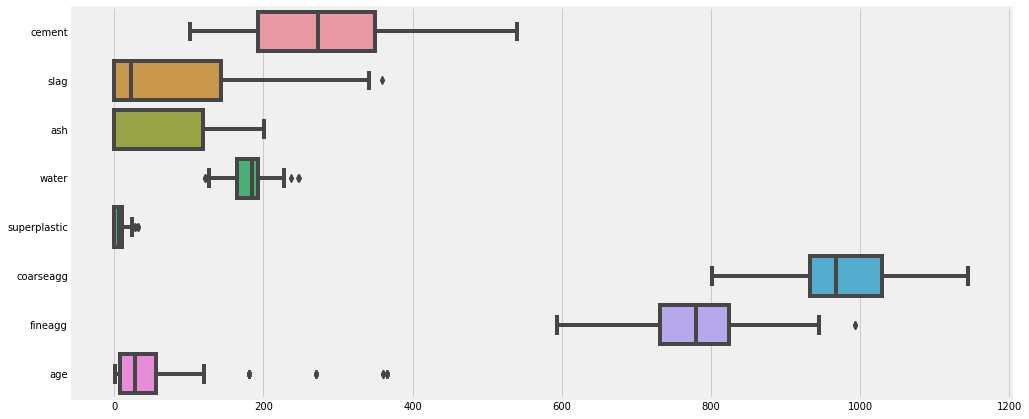

In [11]:
# A quick check to find columns that contain outliers
print('A quick check to find columns that contain outliers, graphical'); print('--'*60)

fig = plt.figure(figsize = (15, 7.2))
ax = sns.boxplot(data = concrete.iloc[:, 0:-1], orient = 'h')

Box plot, distribution of columns with and without outliers
------------------------------------------------------------------------------------------------------------------------
Cement column --------------------------------------------------------------------------------
Number of rows with outliers: 0


Empty DataFrame
Columns: [cement, slag, ash, water, superplastic, coarseagg, fineagg, age, strength]
Index: []

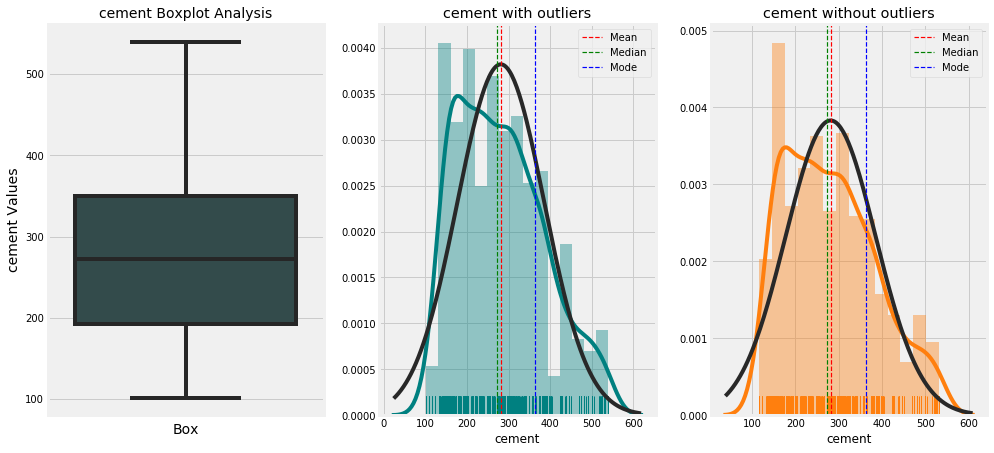

Slag column --------------------------------------------------------------------------------
Number of rows with outliers: 2


cement   slag  ash  water  superplastic  coarseagg  fineagg  age  \
918  239.60 359.40 0.00 185.70          0.00     941.60   664.30   28   
990  239.60 359.40 0.00 185.70          0.00     941.60   664.30    7   

     strength  
918     39.44  
990     25.42

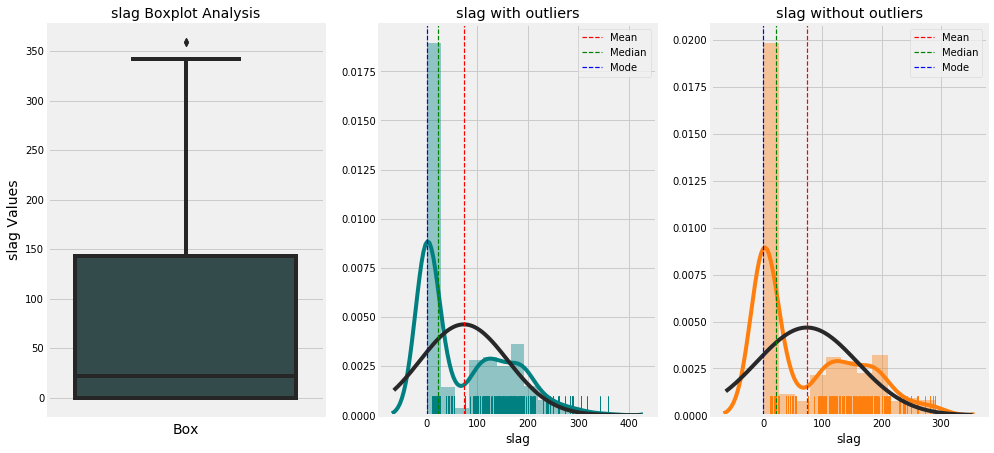

Ash column --------------------------------------------------------------------------------
Number of rows with outliers: 0


Empty DataFrame
Columns: [cement, slag, ash, water, superplastic, coarseagg, fineagg, age, strength]
Index: []

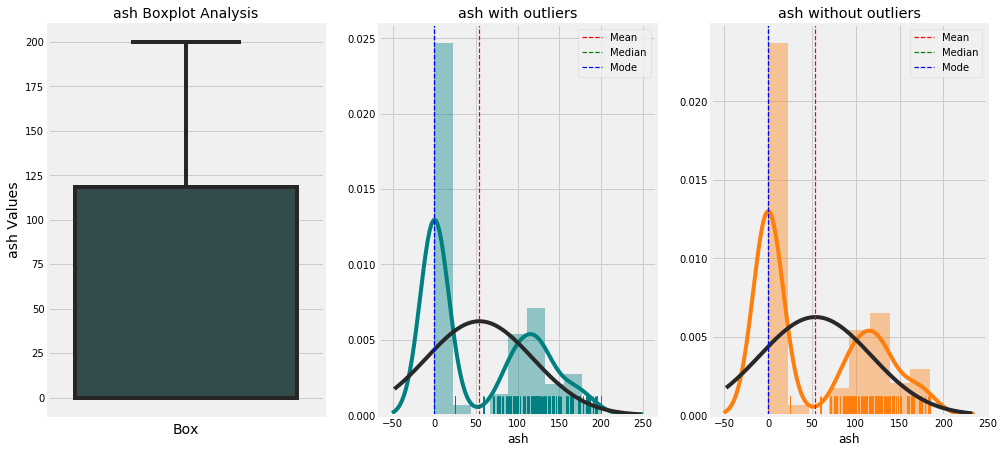

Water column --------------------------------------------------------------------------------
Number of rows with outliers: 9


cement  slag    ash  water  superplastic  coarseagg  fineagg  age  \
66   237.00 92.00  71.00 247.00          6.00     853.00   695.00   28   
263  236.90 91.70  71.50 246.90          6.00     852.90   695.40   28   
432  168.00 42.10 163.80 121.80          5.70    1058.70   780.10   28   
462  168.00 42.10 163.80 121.80          5.70    1058.70   780.10  100   
587  168.00 42.10 163.80 121.80          5.70    1058.70   780.10    3   

     strength  
66      28.63  
263     28.63  
432     24.24  
462     39.23  
587      7.75

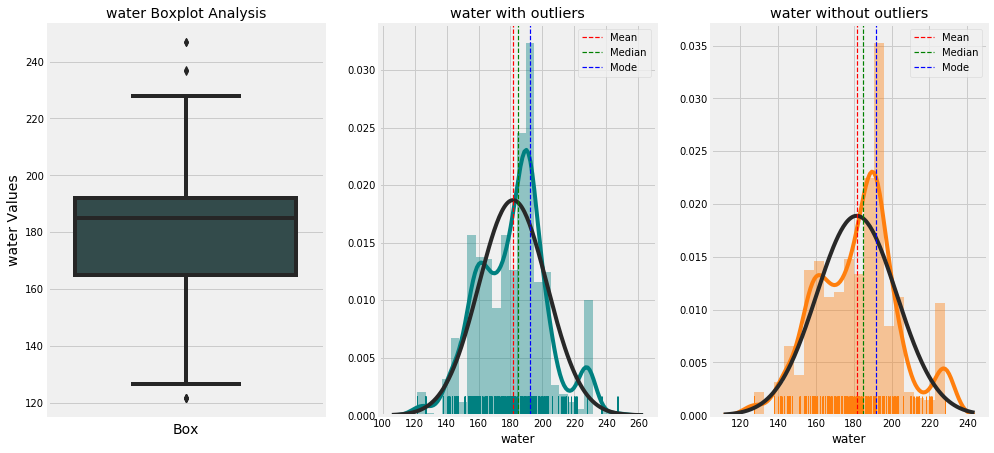

Superplastic column --------------------------------------------------------------------------------
Number of rows with outliers: 10


cement   slag  ash  water  superplastic  coarseagg  fineagg  age  \
44   531.30   0.00 0.00 141.80         28.20     852.10   893.70   91   
156  531.30   0.00 0.00 141.80         28.20     852.10   893.70   28   
232  469.00 117.20 0.00 137.80         32.20     852.10   840.50   56   
292  469.00 117.20 0.00 137.80         32.20     852.10   840.50   91   
538  531.30   0.00 0.00 141.80         28.20     852.10   893.70    7   

     strength  
44      59.20  
156     56.40  
232     69.30  
292     70.70  
538     46.90

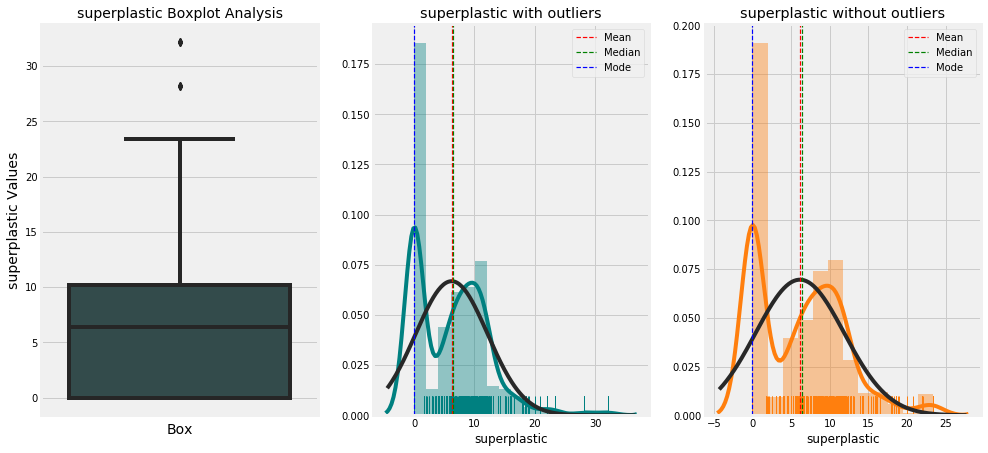

Coarseagg column --------------------------------------------------------------------------------
Number of rows with outliers: 0


Empty DataFrame
Columns: [cement, slag, ash, water, superplastic, coarseagg, fineagg, age, strength]
Index: []

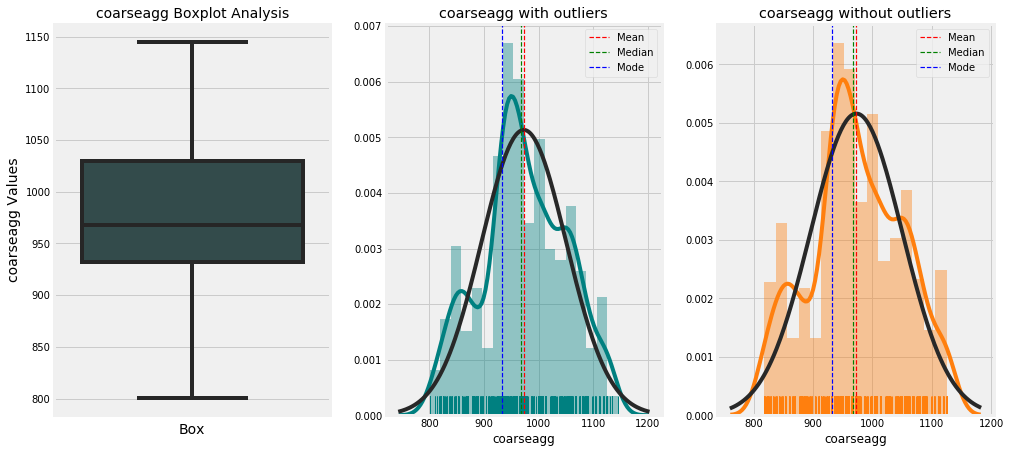

Fineagg column --------------------------------------------------------------------------------
Number of rows with outliers: 5


cement  slag  ash  water  superplastic  coarseagg  fineagg  age  strength
129  375.00 93.80 0.00 126.60         23.40     852.10   992.60   91     62.50
447  375.00 93.80 0.00 126.60         23.40     852.10   992.60    7     45.70
504  375.00 93.80 0.00 126.60         23.40     852.10   992.60    3     29.00
584  375.00 93.80 0.00 126.60         23.40     852.10   992.60   56     60.20
857  375.00 93.80 0.00 126.60         23.40     852.10   992.60   28     56.70

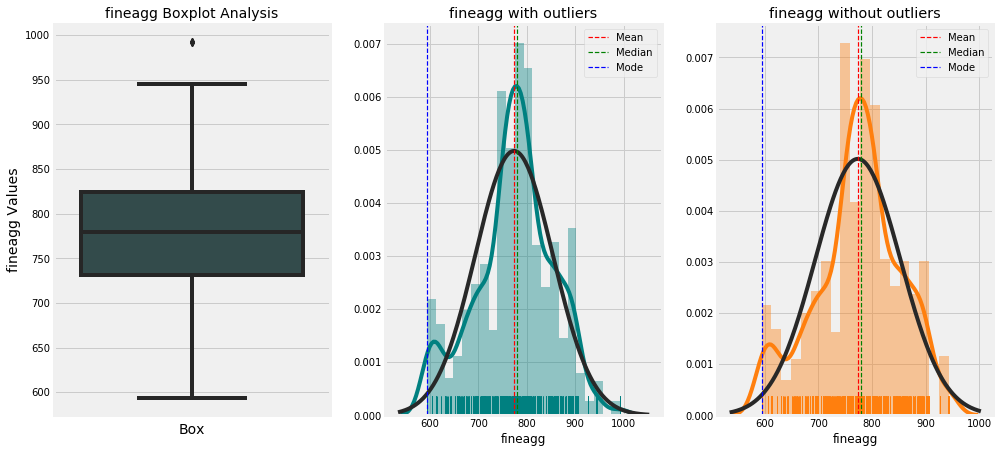

Age column --------------------------------------------------------------------------------
Number of rows with outliers: 59


cement   slag  ash  water  superplastic  coarseagg  fineagg  age  \
51   331.00   0.00 0.00 192.00          0.00     978.00   825.00  180   
64   332.50 142.50 0.00 228.00          0.00     932.00   594.00  365   
93   427.50  47.50 0.00 228.00          0.00     932.00   594.00  180   
99   237.50 237.50 0.00 228.00          0.00     932.00   594.00  180   
103  380.00   0.00 0.00 228.00          0.00     932.00   670.00  180   

     strength  
51      39.00  
64      41.05  
93      41.84  
99      36.25  
103     53.10

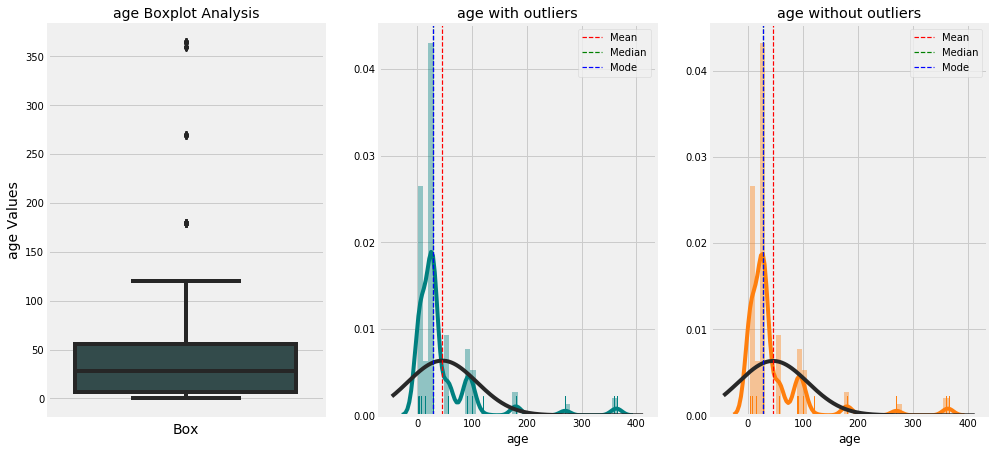

In [12]:
# Outlier, distribution for columns with outliers
print('Box plot, distribution of columns with and without outliers'); print('--'*60)

boxplotcolumns = list(concrete.columns)[:-1]
for cols in boxplotcolumns:
    Q3 = concrete[cols].quantile(0.75)
    Q1 = concrete[cols].quantile(0.25)
    IQR = Q3 - Q1

    print(f'{cols.capitalize()} column', '--'*40)
    print(f'Number of rows with outliers: {len(concrete.loc[(concrete[cols] < (Q1 - 1.5 * IQR)) | (concrete[cols] > (Q3 + 1.5 * IQR))])}')
    display(concrete.loc[(concrete[cols] < (Q1 - 1.5 * IQR)) | (concrete[cols] > (Q3 + 1.5 * IQR))].head())
    odp_plots(concrete, cols)

del cols, IQR, boxplotcolumns

In [13]:
# Replacing outliers with mean values in these columns
print('Replacing outliers with mean values using quantile method'); print('--'*60)

concrete_im = concrete.copy(deep = True)
outliers_cols = ['slag', 'water', 'superplastic', 'fineagg', 'age']

for col in outliers_cols:
    outliers(concrete_im, col, method = 'quantile', strategy = 'mean')

print('\nColumn for which outliers where replaced with mean using quantile method: \n', outliers_cols)

Replacing outliers with mean values using quantile method
------------------------------------------------------------------------------------------------------------------------
Outliers for slag are: [359.4, 359.4]

Outliers for water are: [121.8, 121.8, 121.8, 121.8, 121.8, 236.7, 237.0, 246.9, 247.0]

Outliers for superplastic are: [28.2, 28.2, 28.2, 28.2, 28.2, 32.2, 32.2, 32.2, 32.2, 32.2]

Outliers for fineagg are: [992.6, 992.6, 992.6, 992.6, 992.6]

Outliers for age are: [180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 360, 360, 360, 360, 360, 360, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365]


Column for which outliers where replaced with mean using quantile method: 
 ['slag', 'water', 'superplastic', 'fineagg', 'age']


In [14]:
print('Summary stats before outlier removal for columns with outliers'); print('--'*60); display(concrete[outliers_cols].describe().T)
print('\nSummary stats after outlier removal for columns with outliers'); print('--'*60); display(concrete_im[outliers_cols].describe().T)

Summary stats before outlier removal for columns with outliers
------------------------------------------------------------------------------------------------------------------------


count   mean   std    min    25%    50%    75%    max
slag         1030.00  73.90 86.28   0.00   0.00  22.00 142.95 359.40
water        1030.00 181.57 21.35 121.80 164.90 185.00 192.00 247.00
superplastic 1030.00   6.20  5.97   0.00   0.00   6.40  10.20  32.20
fineagg      1030.00 773.58 80.18 594.00 730.95 779.50 824.00 992.60
age          1030.00  45.66 63.17   1.00   7.00  28.00  56.00 365.00


Summary stats after outlier removal for columns with outliers
------------------------------------------------------------------------------------------------------------------------


count   mean   std    min    25%    50%    75%    max
slag         1030.00  73.34 85.35   0.00   0.00  22.00 142.73 342.10
water        1030.00 181.62 20.60 126.60 164.90 185.00 192.00 228.00
superplastic 1030.00   5.97  5.48   0.00   0.00   6.20  10.07  23.40
fineagg      1030.00 772.52 78.70 594.00 730.95 778.90 822.20 945.00
age          1030.00  33.27 27.95   1.00   7.00  28.00  45.66 120.00

<a id='o4'></a>
#### Observation 4 - After imputation
A quick observation after imputating the missing values: medians remain unchanged while mean changes slightly not significantly. Type of skewness remain unchanged.

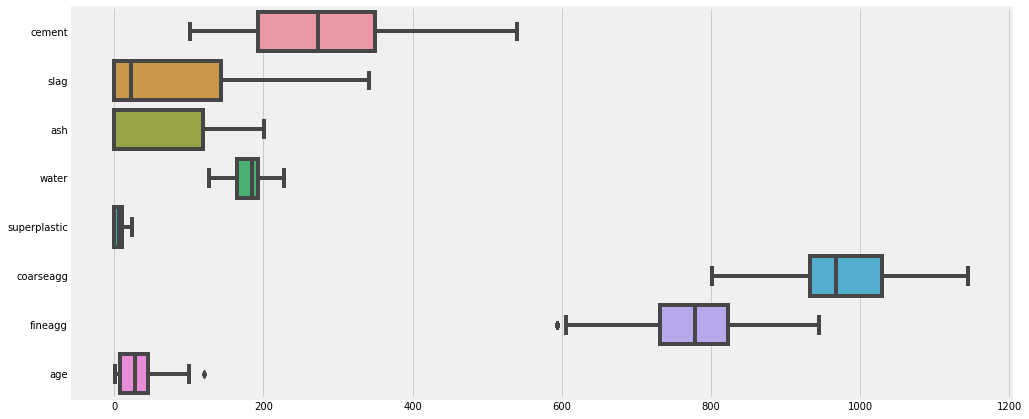

In [15]:
# A quick check to find columns that contain outliers
fig = plt.figure(figsize = (15, 7.2))
ax = sns.boxplot(data = concrete_im.iloc[:, 0:-1], orient = 'h')

cement and strength column have a linear relationship
------------------------------------------------------------------------------------------------------------------------


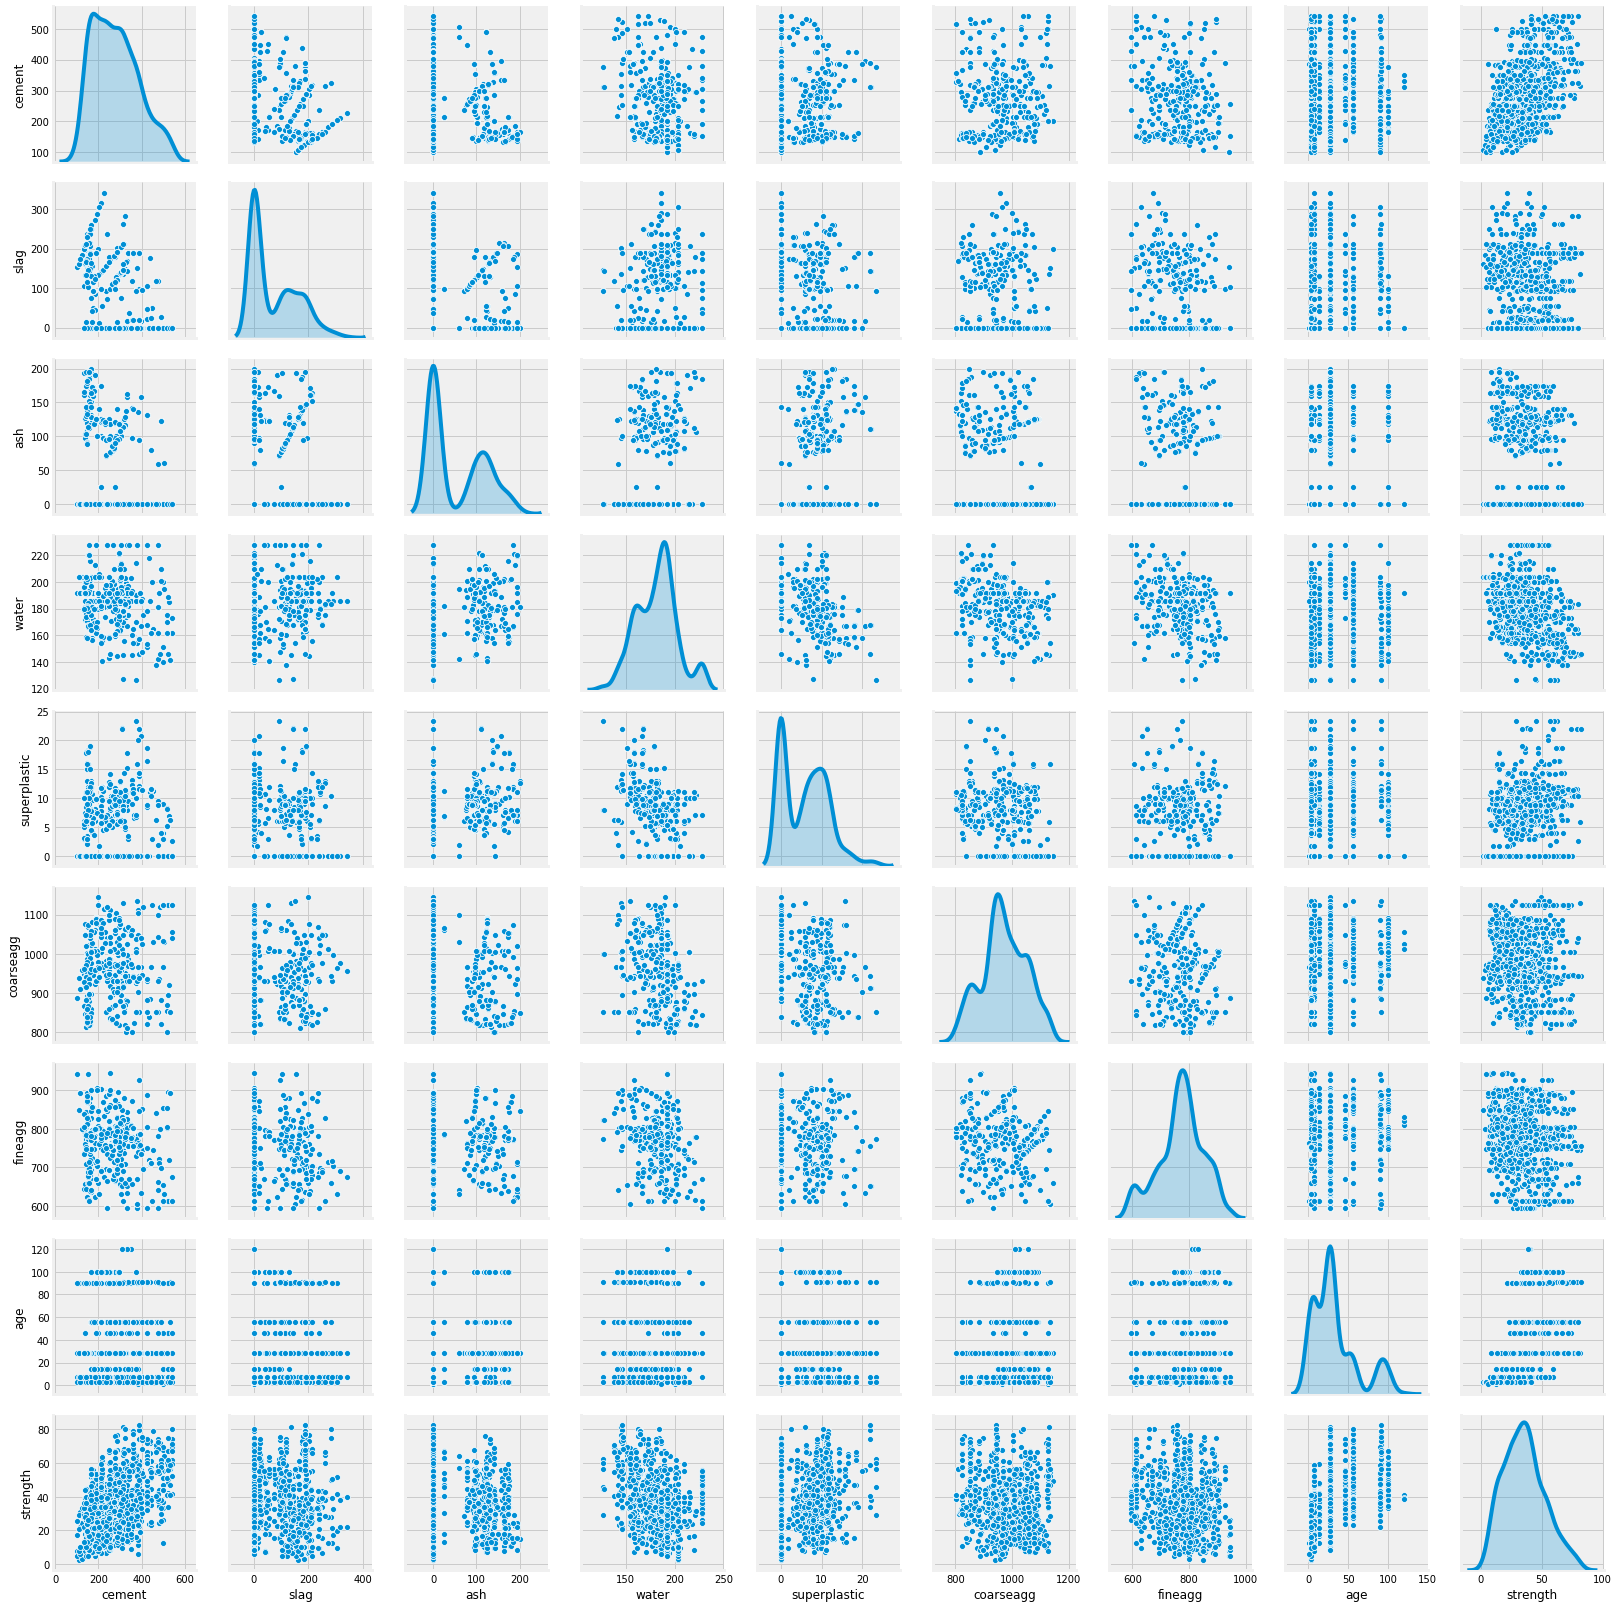

In [16]:
print('cement and strength column have a linear relationship'); print('--'*60)
sns.pairplot(concrete_im, diag_kind = 'kde')

<a id='o5'></a>
#### Observation 5 - Pairplot comments
* Cement and strength have a linear relationship.
* Column that have bi/multimodal distributions are slag, ash and superplastic.

<a id='multi'></a>
### Multivariate analysis

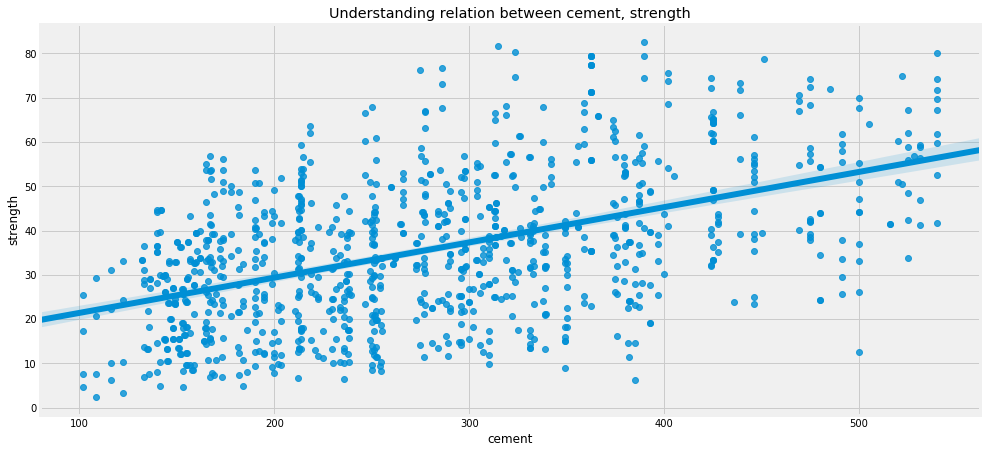

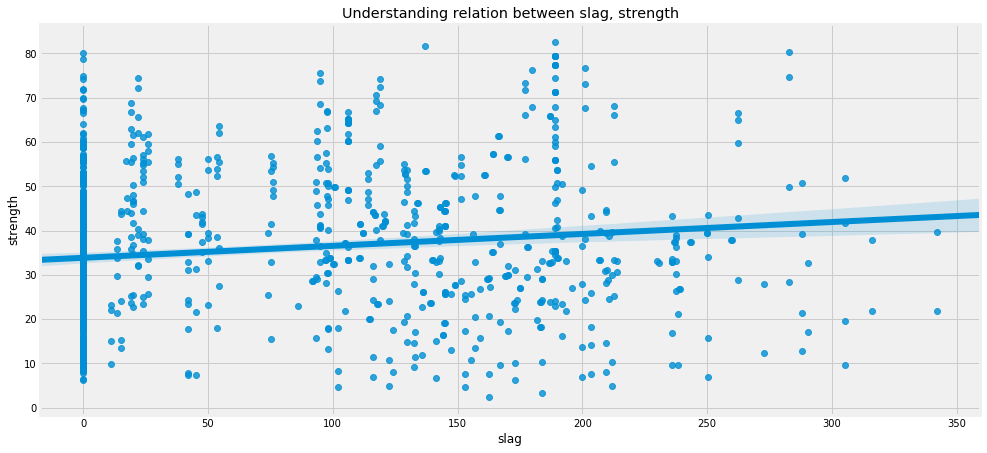

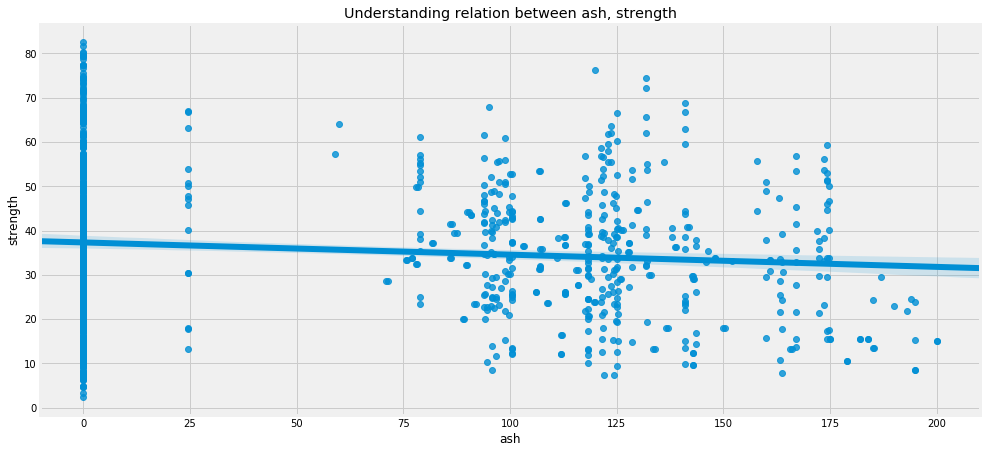

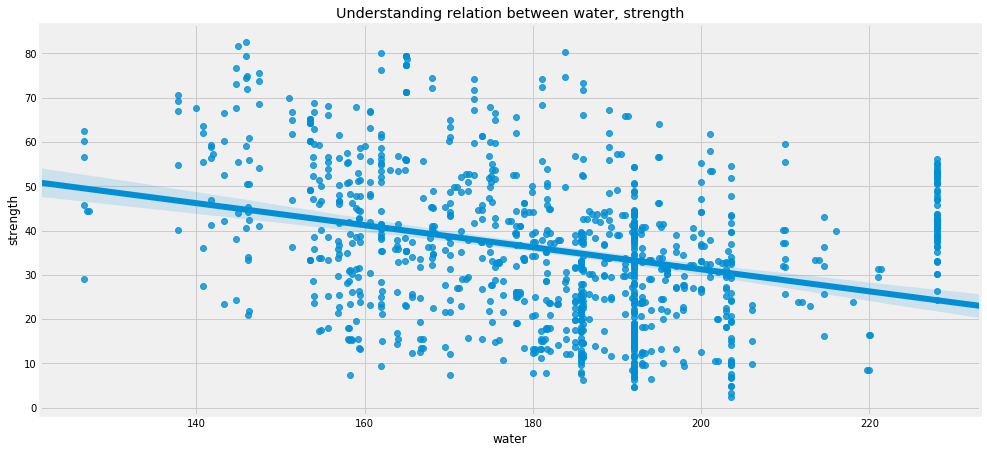

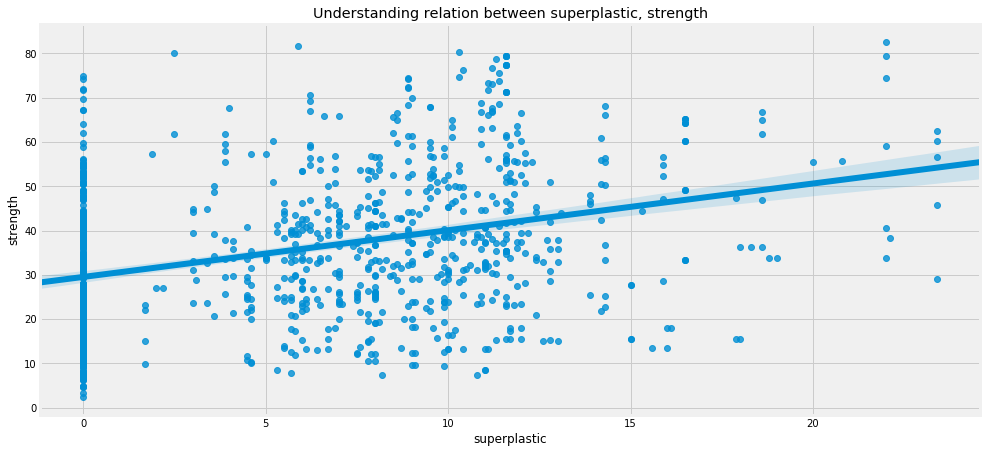

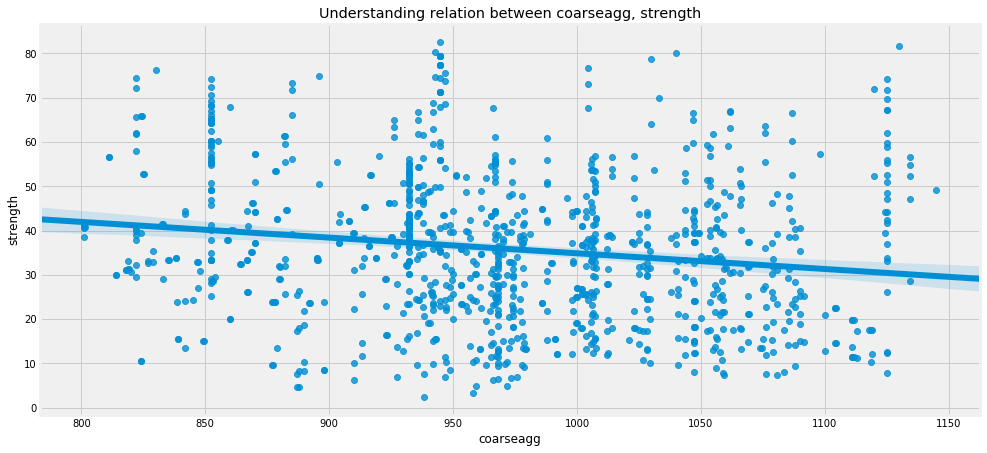

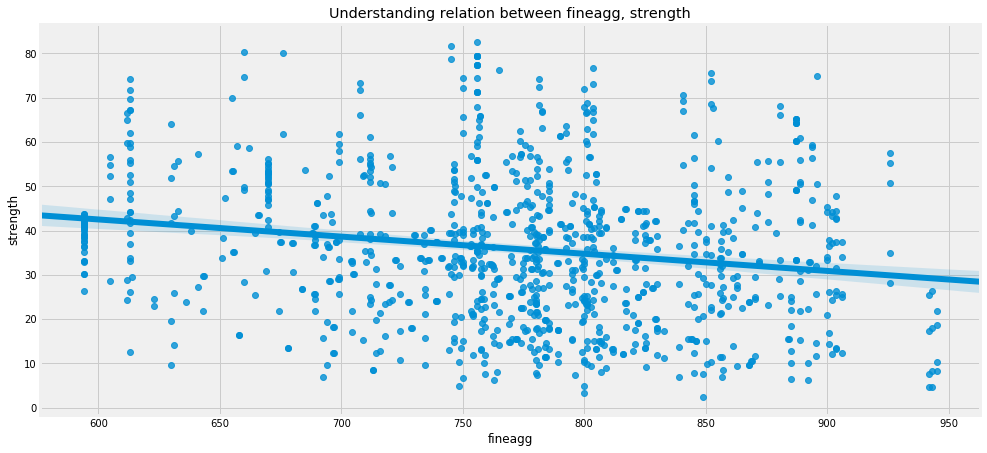

In [17]:
for col in list(concrete_im.columns)[:-2]:
    fig, ax1 = plt.subplots(figsize = (15, 7.2), ncols = 1, sharex = False)
    sns.regplot(x = concrete_im[col], y = concrete_im['strength'], ax = ax1).set_title(f'Understanding relation between {col}, strength')

<a id='leverage'></a>
#### Leverage Analysis
[Reference for carrying out this analysis](https://songhuiming.github.io/pages/2016/12/31/linear-regression-in-python-chapter-2/)

**Leverage**: An observation with an extreme value on a predictor variable is called a point with high leverage. Leverage is a measure of how far an observation deviates from the mean of that variable. These leverage points can have an effect on the estimate of regression coefficients.

**Influence**: An observation is said to be influential if removing the observation substantially changes the estimate of coefficients. Influence can be thought of as the product of leverage and outlierness.

                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     365.7
Date:                Sun, 08 Dec 2019   Prob (F-statistic):          1.53e-293
Time:                        14:39:18   Log-Likelihood:                -3664.9
No. Observations:                1030   AIC:                             7348.
Df Residuals:                    1021   BIC:                             7392.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       32.1465     18.667      1.722   

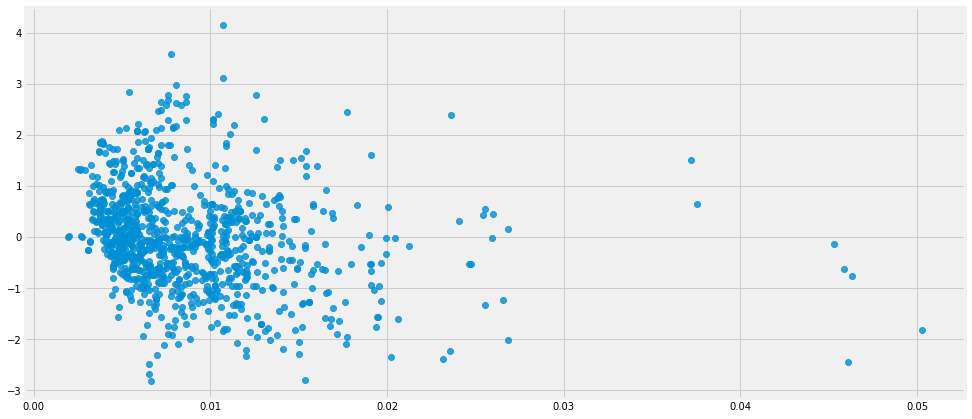

In [18]:
lm = smf.ols(formula = 'strength ~ cement + slag + ash + water + superplastic + coarseagg + fineagg + age', data = concrete_im).fit()
print(lm.summary())

influence = lm.get_influence()
resid_student = influence.resid_studentized_external
(cooks, p) = influence.cooks_distance
(dffits, p) = influence.dffits
leverage = influence.hat_matrix_diag

print('\n')
print('Leverage v.s. Studentized Residuals')
fig = plt.figure(figsize = (15, 7.2))
sns.regplot(leverage, lm.resid_pearson,  fit_reg = False)

In [19]:
concrete_im_res = pd.concat([pd.Series(cooks, name = 'cooks'), pd.Series(dffits, name = 'dffits'), pd.Series(leverage, name = 'leverage'), pd.Series(resid_student, name = 'resid_student')], axis = 1)
concrete_im_res = pd.concat([concrete_im, concrete_im_res], axis = 1)
concrete_im_res.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg   age  \
0  141.30 212.00   0.00 203.50          0.00     971.80   748.50 28.00   
1  168.90  42.20 124.30 158.30         10.80    1080.80   796.20 14.00   
2  250.00   0.00  95.70 187.40          5.50     956.90   861.20 28.00   
3  266.00 114.00   0.00 228.00          0.00     932.00   670.00 28.00   
4  154.80 183.40   0.00 193.30          9.10    1047.40   696.70 28.00   

   strength  cooks  dffits  leverage  resid_student  
0     29.89   0.00    0.07      0.01           0.86  
1     23.51   0.00   -0.00      0.01          -0.02  
2     29.22   0.00    0.03      0.00           0.48  
3     45.85   0.00    0.21      0.01           2.49  
4     18.29   0.00   -0.10      0.01          -0.96

In [20]:
# Studentized Residual
print('Studentized residuals as a first means for identifying outliers'); print('--'*60)
r = concrete_im_res.resid_student
print('-'*30 + ' studentized residual ' + '-'*30)
display(r.describe())
print('\n')

r_sort = concrete_im_res.sort_values(by = 'resid_student', ascending = True)
print('-'*30 + ' top 5 most negative residuals ' + '-'*30)
display(r_sort.head())
print('\n')

r_sort = concrete_im_res.sort_values(by = 'resid_student', ascending = False)
print('-'*30 + ' top 5 most positive residuals ' + '-'*30)
display(r_sort.head())

Studentized residuals as a first means for identifying outliers
------------------------------------------------------------------------------------------------------------------------
------------------------------ studentized residual ------------------------------


count   1030.00
mean      -0.00
std        1.00
min       -2.83
25%       -0.62
50%       -0.06
75%        0.55
max        4.22
Name: resid_student, dtype: float64



------------------------------ top 5 most negative residuals ------------------------------


cement   slag   ash  water  superplastic  coarseagg  fineagg  age  \
502  500.00   0.00  0.00 200.00          0.00    1125.00   613.00 1.00   
503  362.60 189.00  0.00 164.90         11.60     944.70   755.80 7.00   
786  446.00  24.00 79.00 162.00         11.60     967.00   712.00 3.00   
504  375.00  93.80  0.00 126.60         23.40     852.10   773.58 3.00   
993  446.00  24.00 79.00 162.00         11.60     967.00   712.00 3.00   

     strength  cooks  dffits  leverage  resid_student  
502     12.64   0.01   -0.35      0.02          -2.83  
503     22.90   0.01   -0.23      0.01          -2.83  
786     23.35   0.01   -0.22      0.01          -2.69  
504     29.00   0.03   -0.55      0.05          -2.50  
993     25.02   0.00   -0.20      0.01          -2.50



------------------------------ top 5 most positive residuals ------------------------------


cement   slag    ash  water  superplastic  coarseagg  fineagg   age  \
192  315.00 137.00   0.00 145.00          5.90    1130.00   745.00 28.00   
506  451.00   0.00   0.00 165.00         11.30    1030.00   745.00 28.00   
491  275.00 180.00 120.00 162.00         10.40     830.00   765.00 28.00   
713  190.00 190.00   0.00 228.00          0.00     932.00   670.00 45.66   
964  277.20  97.80  24.50 160.70         11.20    1061.70   782.50 28.00   

     strength  cooks  dffits  leverage  resid_student  
192     81.75   0.02    0.44      0.01           4.22  
506     78.80   0.01    0.32      0.01           3.63  
491     76.24   0.01    0.33      0.01           3.14  
713     53.69   0.01    0.27      0.01           3.00  
964     63.14   0.00    0.21      0.01           2.86

We should pay attention to studentized residuals that exceed +2 or -2, and get even more concerned about residuals that exceed +2.5 or -2.5 and even yet more concerned about residuals that exceed +3 or -3. 

In [21]:
print('Printing indexes where studentized residual exceeds +2 or -2'); print('--'*60)
res_index = concrete_im_res[abs(r) > 2].index
print(res_index)

Printing indexes where studentized residual exceeds +2 or -2
------------------------------------------------------------------------------------------------------------------------
Int64Index([   3,   44,   50,   96,  103,  128,  147,  159,  161,  192,  198,
             207,  262,  264,  272,  302,  329,  334,  349,  370,  383,  393,
             434,  452,  469,  491,  502,  503,  504,  506,  510,  518,  525,
             530,  539,  545,  556,  570,  606,  623,  632,  713,  732,  734,
             738,  762,  786,  824,  831,  902,  908,  964,  967,  973,  981,
             993,  995, 1003, 1009, 1021, 1028],
           dtype='int64')


In [22]:
print('Let\'s look at leverage points to identify observations that will have potential great influence on reg coefficient estimates.'); print('--'*60)
print('A point with leverage greater than (2k+2)/n should be carefully examined, where k is the number of predictors and n is the number of observations. In our example this works out to (2*8+2)/1030 = .017476')

leverage = concrete_im_res.leverage
print('-'*30 + ' Leverage ' + '-'*30)
display(leverage.describe())
print('\n')

leverage_sort = concrete_im_res.sort_values(by = 'leverage', ascending = False)

print('-'*30 + ' top 5 highest leverage data points ' + '-'*30)
display(leverage_sort.head())

Let's look at leverage points to identify observations that will have potential great influence on reg coefficient estimates.
------------------------------------------------------------------------------------------------------------------------
A point with leverage greater than (2k+2)/n should be carefully examined, where k is the number of predictors and n is the number of observations. In our example this works out to (2*8+2)/1030 = .017476
------------------------------ Leverage ------------------------------


count   1030.00
mean       0.01
std        0.01
min        0.00
25%        0.01
50%        0.01
75%        0.01
max        0.05
Name: leverage, dtype: float64



------------------------------ top 5 highest leverage data points ------------------------------


cement  slag  ash  water  superplastic  coarseagg  fineagg   age  \
129  375.00 93.80 0.00 126.60         23.40     852.10   773.58 91.00   
584  375.00 93.80 0.00 126.60         23.40     852.10   773.58 56.00   
504  375.00 93.80 0.00 126.60         23.40     852.10   773.58  3.00   
447  375.00 93.80 0.00 126.60         23.40     852.10   773.58  7.00   
857  375.00 93.80 0.00 126.60         23.40     852.10   773.58 28.00   

     strength  cooks  dffits  leverage  resid_student  
129     62.50   0.02   -0.43      0.05          -1.86  
584     60.20   0.00   -0.17      0.05          -0.79  
504     29.00   0.03   -0.55      0.05          -2.50  
447     45.70   0.00   -0.14      0.05          -0.65  
857     56.70   0.00   -0.03      0.05          -0.13

In [23]:
print('Printing indexes where leverage exceeds +0.017476 or -0.017476'); print('--'*60)
lev_index = concrete_im_res[abs(leverage) > 0.017476].index
print(lev_index)

Printing indexes where leverage exceeds +0.017476 or -0.017476
------------------------------------------------------------------------------------------------------------------------
Int64Index([  21,   44,   63,   66,   95,  129,  156,  212,  232,  234,  263,
             292,  300,  307,  447,  452,  469,  490,  504,  538,  540,  553,
             556,  584,  608,  614,  615,  740,  741,  744,  788,  816,  817,
             826,  838,  846,  857,  869,  889,  902,  908,  918,  950,  955,
             973,  990, 1000, 1026],
           dtype='int64')


In [24]:
print('Let\'s take a look at DFITS. The conventional cut-off point for DFITS is 2*sqrt(k/n).')
print('DFITS can be either positive or negative, with numbers close to zero corresponding to the points with small or zero influence.'); print('--'*60)

import math
dffits_index = concrete_im_res[concrete_im_res['dffits'] > 2 * math.sqrt(8 / 1030)].index
print(dffits_index)

Let's take a look at DFITS. The conventional cut-off point for DFITS is 2*sqrt(k/n).
DFITS can be either positive or negative, with numbers close to zero corresponding to the points with small or zero influence.
------------------------------------------------------------------------------------------------------------------------
Int64Index([   3,   50,   86,  103,  128,  147,  159,  161,  192,  198,  207,
             262,  273,  302,  313,  320,  323,  329,  349,  370,  393,  452,
             469,  491,  506,  539,  545,  570,  593,  608,  623,  632,  713,
             732,  824,  918,  935,  964,  995, 1003, 1017, 1028],
           dtype='int64')


In [25]:
set(res_index).intersection(lev_index).intersection(dffits_index)

{452, 469}

In [26]:
print('Let\'s run the regression again without 452 and 469 row'); print('--'*60)
concrete_im.drop([452, 469], axis = 0, inplace = True)
print(concrete_im.shape)

lm1 = smf.ols(formula = 'strength ~ cement + slag + ash + water + superplastic + coarseagg + fineagg + age', data = concrete_im).fit()
print(lm1.summary())

Let's run the regression again without 452 and 469 row
------------------------------------------------------------------------------------------------------------------------
(1028, 9)
                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     366.0
Date:                Sun, 08 Dec 2019   Prob (F-statistic):          2.05e-293
Time:                        14:39:20   Log-Likelihood:                -3652.6
No. Observations:                1028   AIC:                             7323.
Df Residuals:                    1019   BIC:                             7368.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef 

Series([], dtype: float64)

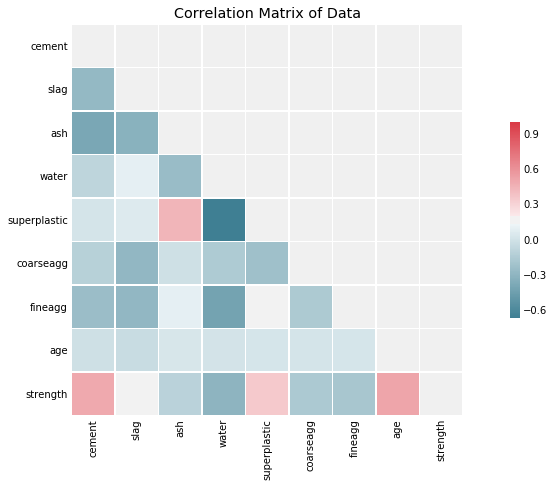

In [27]:
# Correlation matrix
correlation_matrix(concrete_im, 0.8)

In [28]:
# Absolute correlation of independent variables with the target variable
absCorrwithDep = []
allVars = concrete_im.drop('strength', axis = 1).columns

for var in allVars:
    absCorrwithDep.append(abs(concrete_im['strength'].corr(concrete_im[var])))

display(pd.DataFrame([allVars, absCorrwithDep], index = ['Variable', 'Correlation']).T.\
        sort_values('Correlation', ascending = False))

Variable Correlation
7           age        0.52
0        cement        0.49
4  superplastic        0.35
3         water        0.30
6       fineagg        0.19
5     coarseagg        0.17
1          slag        0.14
2           ash        0.10

<a id='o6'></a>
#### Observation 6 - Correlation Matrix
* None of the columns have a correlation above a threshold and thus none to be dropped.
* `age`, `cement` and `superplastic` are some of the columns that have strong influence over target variable. 

<a id='FE'></a>
## Feature Engineering
Performing feature engineering on the cement dataset. Objective here would be:

* Explore for gaussians. If data is likely to be a mix of gaussians, explore individual clusters and present your findings in terms of the independent attributes and their suitability to predict strength
* Identify opportunities (if any) to create a composite feature, drop a feature
* Decide on complexity of the model, should it be simple linear mode in terms of parameters or would a quadratic or higher degree help

<a id='KMeans'></a>
### Identifying if there are any clusters

In [0]:
concrete_im.reset_index(inplace = True, drop = True)

X = concrete_im.drop('strength', axis = 1)
y = concrete_im['strength']
labels = KMeans(2, random_state = random_state).fit_predict(X)

Cement vs other columns clusters
------------------------------------------------------------------------------------------------------------------------


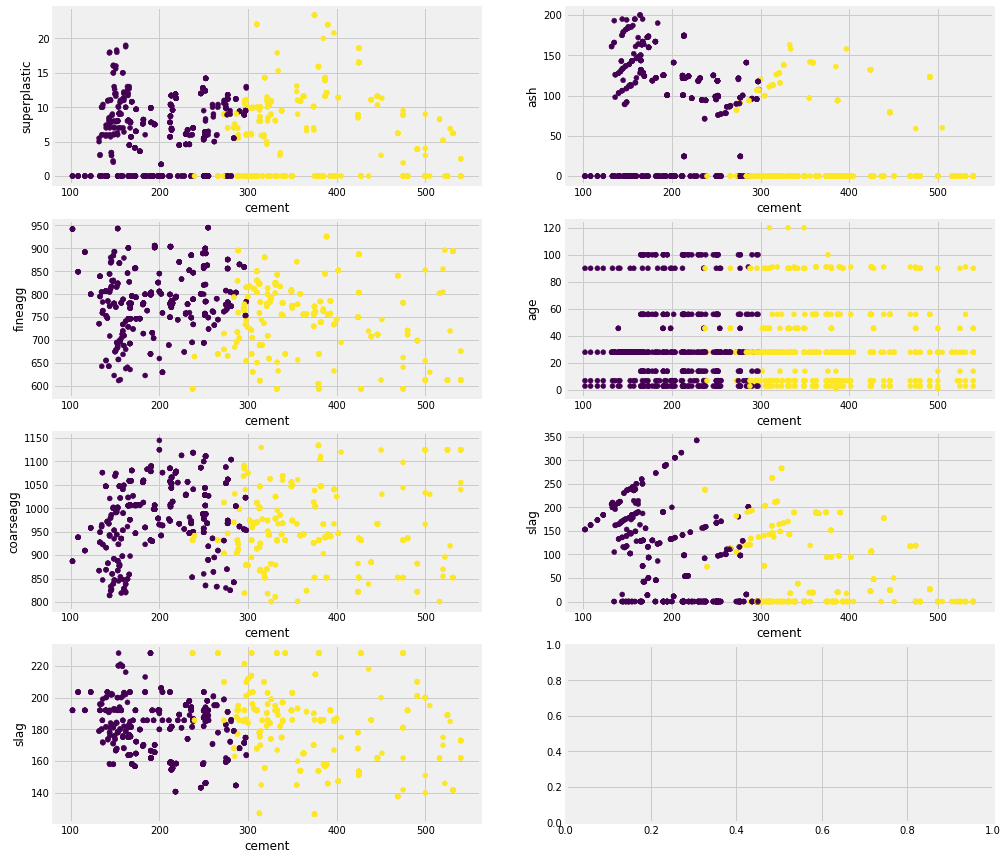

In [30]:
print('Cement vs other columns clusters'); print('--'*60)
kmeans_plots(X, 'cement')

Slag vs other columns clusters
------------------------------------------------------------------------------------------------------------------------


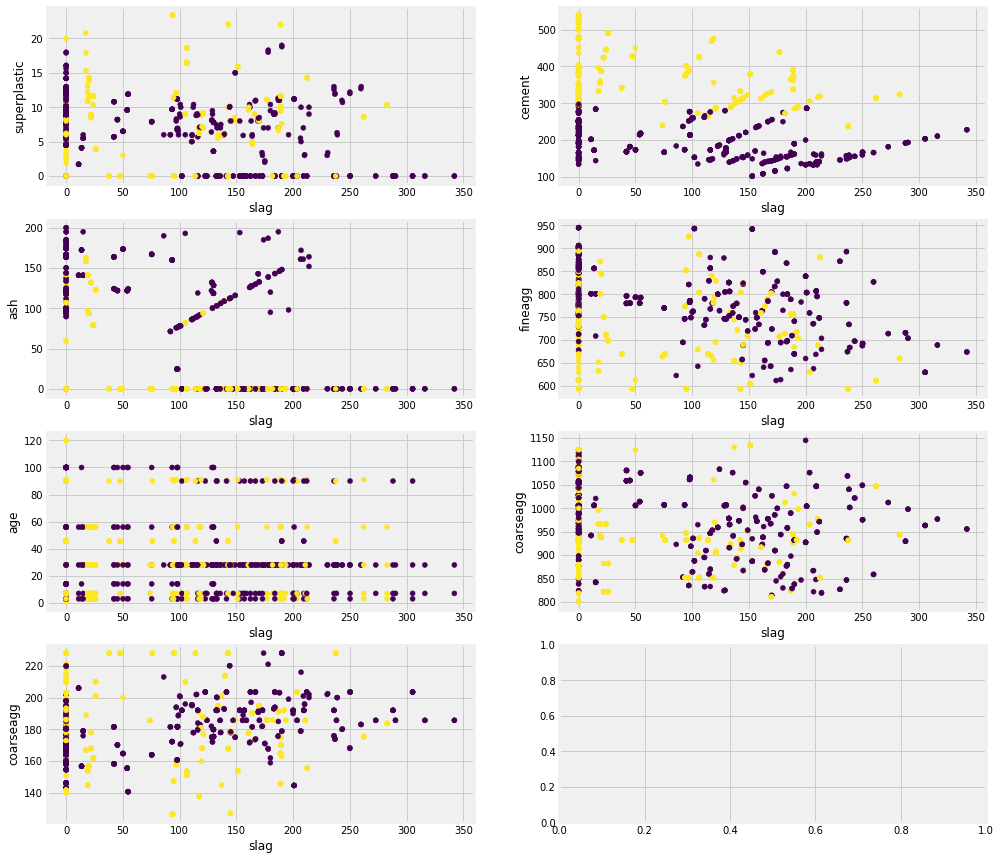

In [31]:
print('Slag vs other columns clusters'); print('--'*60)
kmeans_plots(X, 'slag')

Ash vs other columns clusters
------------------------------------------------------------------------------------------------------------------------


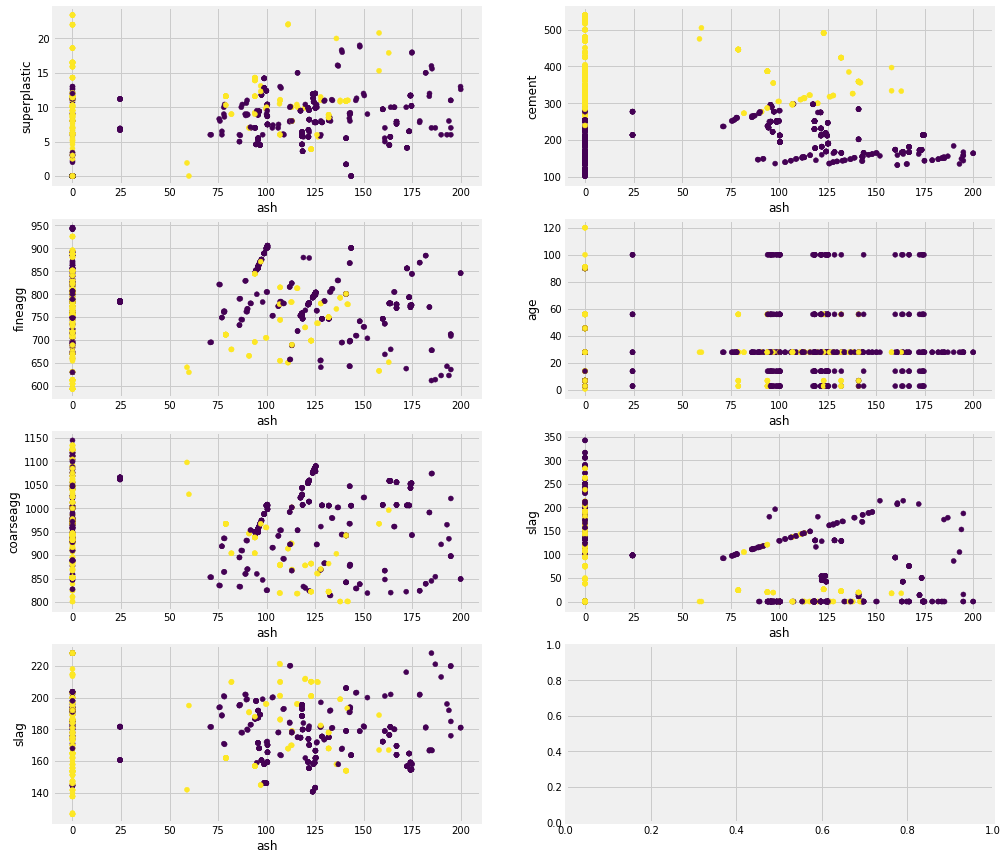

In [32]:
print('Ash vs other columns clusters'); print('--'*60)
kmeans_plots(X, 'ash')

Water vs other columns clusters
------------------------------------------------------------------------------------------------------------------------


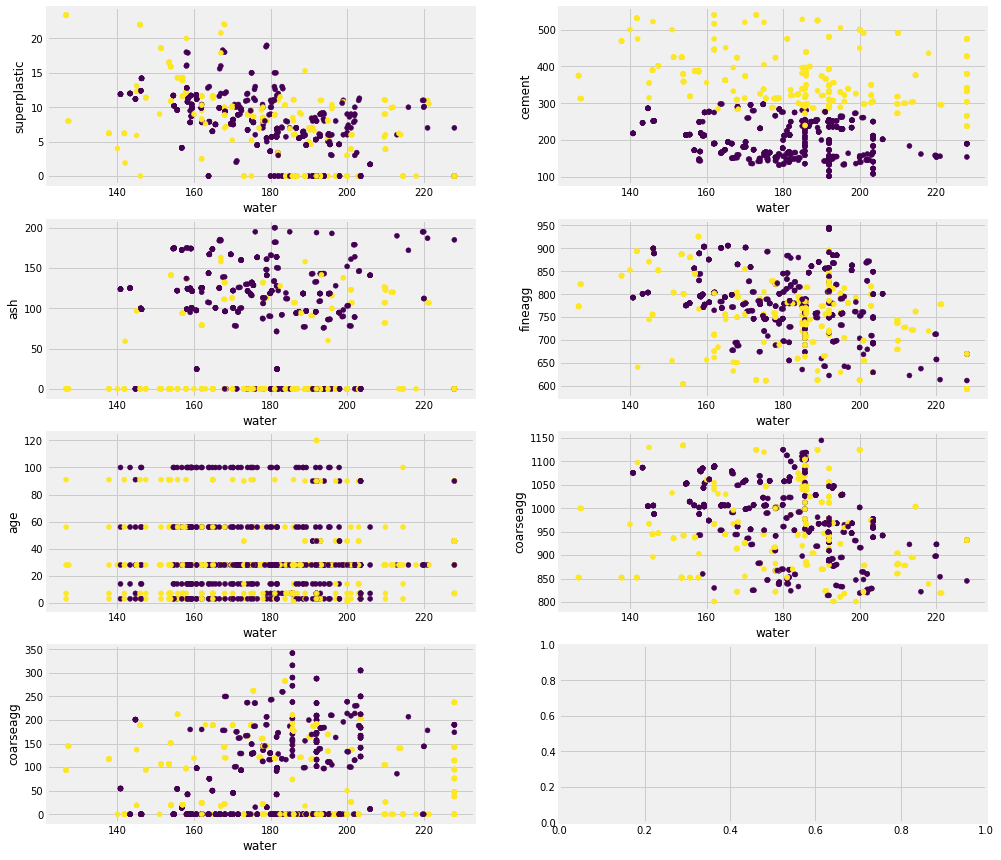

In [33]:
print('Water vs other columns clusters'); print('--'*60)
kmeans_plots(X, 'water')

Superplastic vs other columns clusters
------------------------------------------------------------------------------------------------------------------------


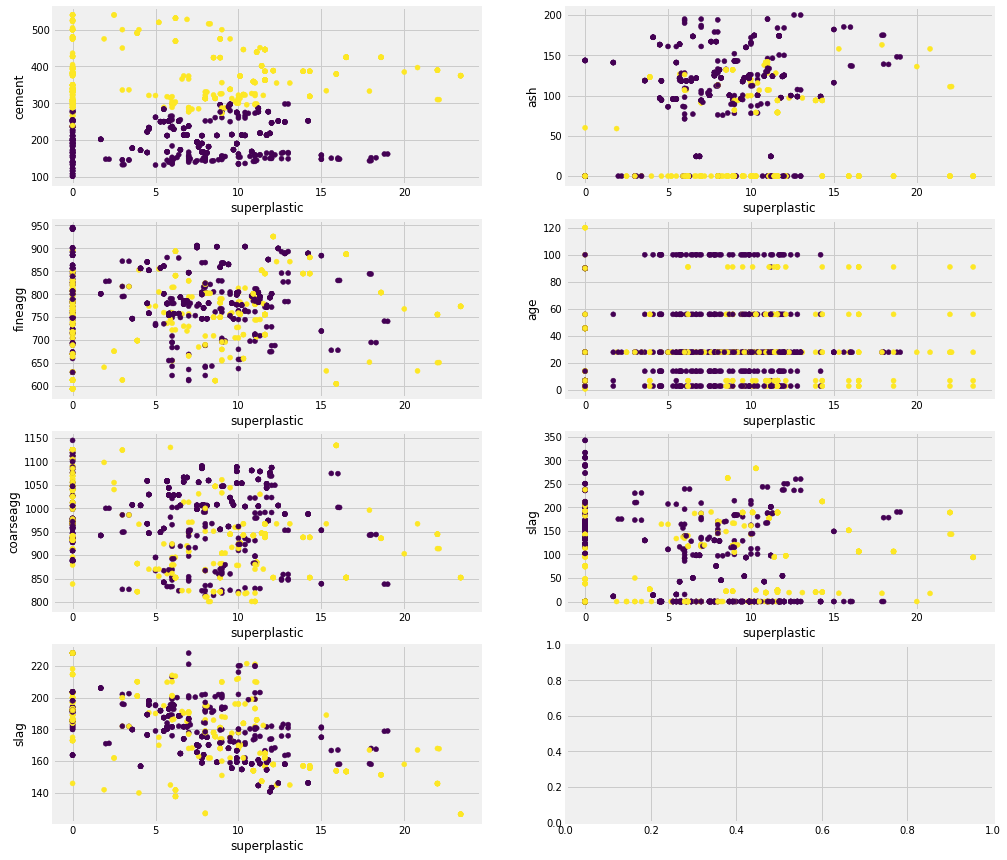

In [34]:
print('Superplastic vs other columns clusters'); print('--'*60)
kmeans_plots(X, 'superplastic')

Coarseagg vs other columns clusters
------------------------------------------------------------------------------------------------------------------------


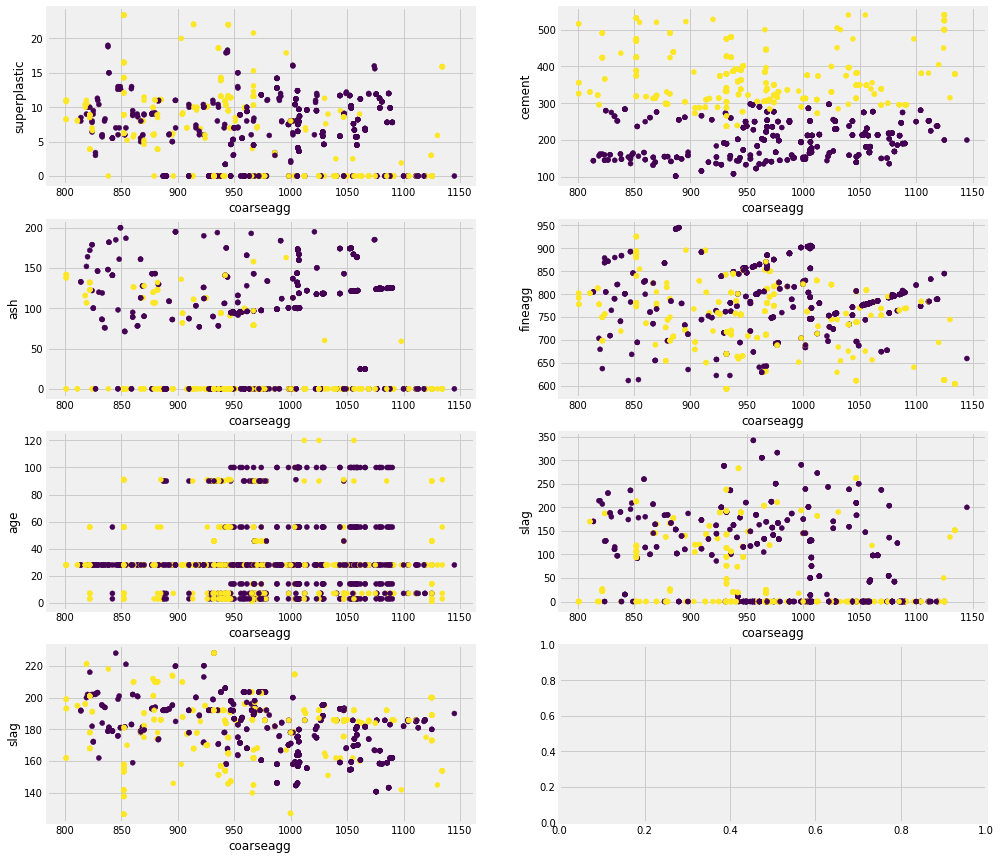

In [35]:
print('Coarseagg vs other columns clusters'); print('--'*60)
kmeans_plots(X, 'coarseagg')

Fineagg vs other columns clusters
------------------------------------------------------------------------------------------------------------------------


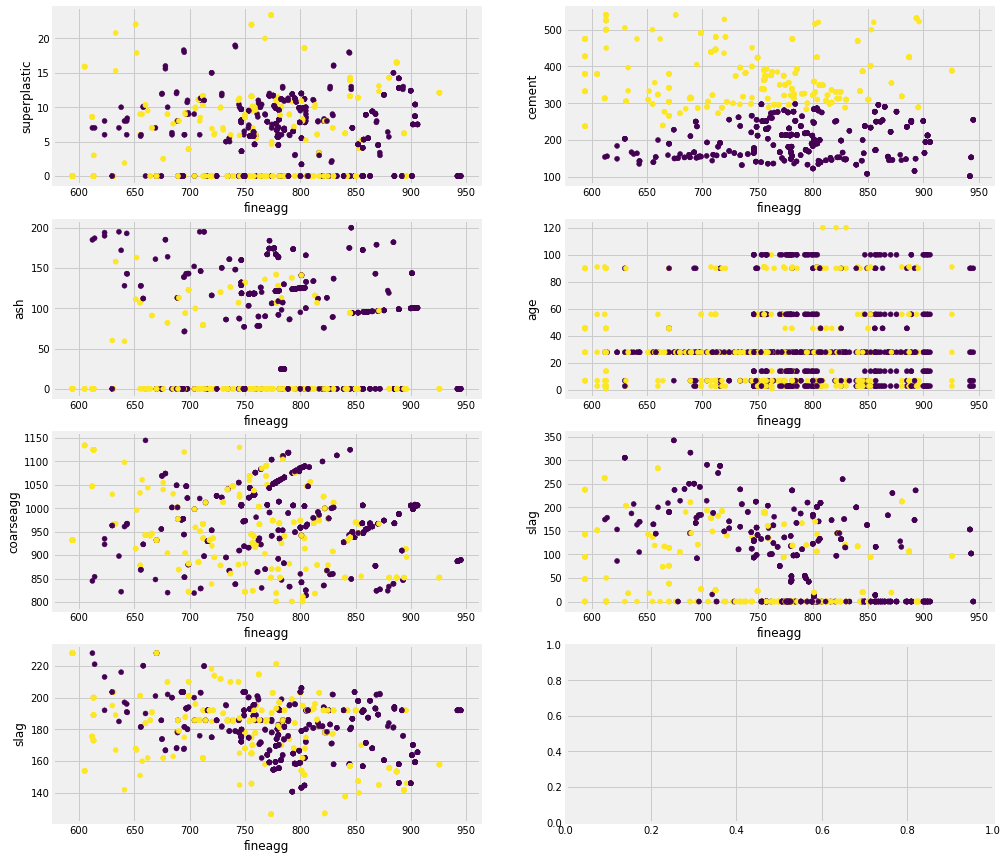

In [36]:
print('Fineagg vs other columns clusters'); print('--'*60)
kmeans_plots(X, 'fineagg')

Fineagg vs other columns clusters
------------------------------------------------------------------------------------------------------------------------


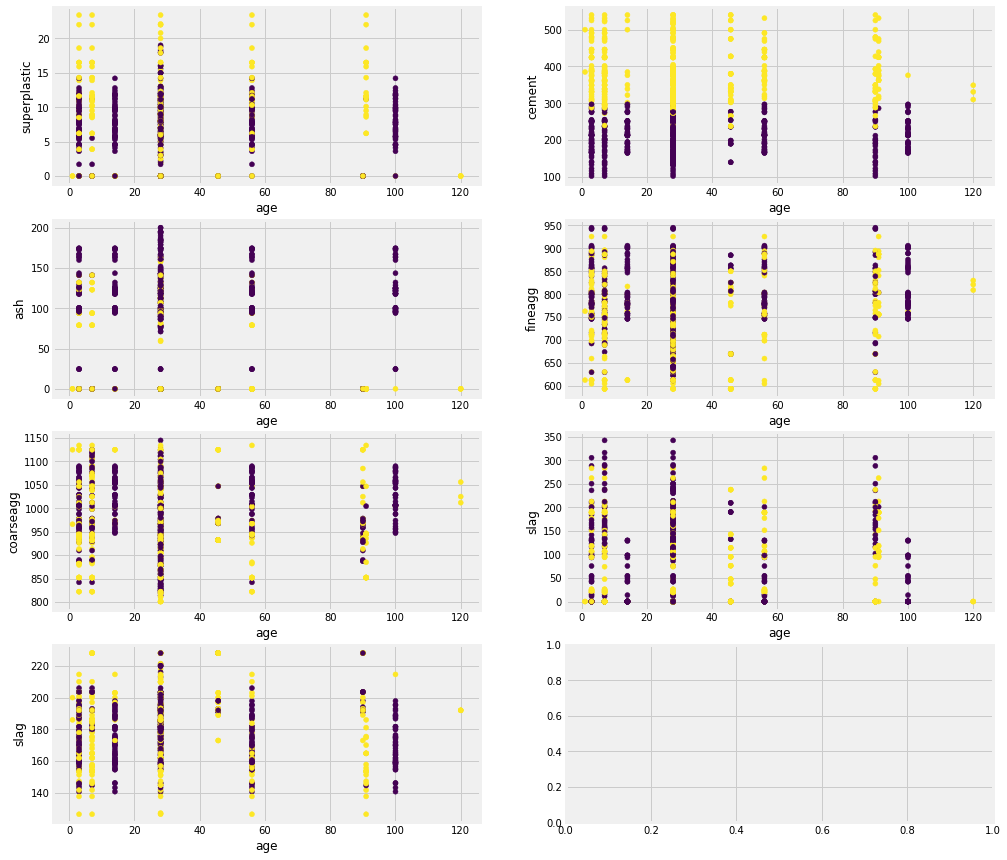

In [37]:
print('Fineagg vs other columns clusters'); print('--'*60)
kmeans_plots(X, 'age')

<a id='o7'></a>
#### Observation 7 - Exploring clusters
* Clusters can be observed with between cement and rest of the independent variables.
* Cluster at age 100 can be seen.

<a id='feature1'></a>
### Adding features based on cluster analysis
Let's add features based on cluster analysis we found for cement and other columns.

In [38]:
# Adding features based on cement clusters
print('Let\'s add features based on cluster analysis we found for cement and other columns'); print('--'*60)

concrete_im = concrete_im.join(pd.DataFrame(labels, columns = ['labels']), how = 'left')
cement_features = concrete_im.groupby('labels', as_index = False)['cement'].agg(['mean', 'median'])
concrete_im = concrete_im.merge(cement_features, on = 'labels', how = 'left')
concrete_im.rename(columns = {'mean': 'cement_labels_mean', 'median': 'cement_labels_median'}, inplace = True)
concrete_im.drop('labels', axis = 1, inplace = True)
display(custom_describe(concrete_im))

Let's add features based on cluster analysis we found for cement and other columns
------------------------------------------------------------------------------------------------------------------------


Count     Type   Mean  StandardDeviation  Variance  \
                                                                           
cement                 1028  float64 280.74             104.14  10845.73   
slag                   1028  float64  73.48              85.38   7289.08   
ash                    1028  float64  54.29              64.01   4097.86   
water                  1028  float64 181.69              20.56    422.74   
superplastic           1028  float64   5.98               5.48     29.99   
coarseagg              1028  float64 972.85              77.66   6030.62   
fineagg                1028  float64 772.37              78.68   6190.43   
age                    1028  float64  33.28              27.98    782.75   
strength               1028  float64  35.74              16.64    276.85   
cement_labels_mean     1028  float64 280.74              85.39   7292.30   
cement_labels_median   1028  float64 274.50              81.05   6569.82   

                      Minimum     Q1  Median      Q3  Maximum  Range    IQR  \
                                                                              
cement                 102.00 192.00  272.80  350.00   540.00 438.00 158.00   
slag                     0.00   0.00   22.00  142.80   342.10 342.10 142.80   
ash                      0.00   0.00    0.00  118.30   200.10 200.10 118.30   
water                  126.60 164.90  185.00  192.00   228.00 101.40  27.10   
superplastic             0.00   0.00    6.20   10.10    23.40  23.40  10.10   
coarseagg              801.00 932.00  968.00 1029.40  1145.00 344.00  97.40   
fineagg                594.00 730.30  778.50  822.20   945.00 351.00  91.90   
age                      1.00   7.00   28.00   45.66   120.00 119.00  38.66   
strength                 2.33  23.70   34.34   45.91    82.60  80.27  22.21   
cement_labels_mean     202.25 202.25  202.25  373.55   373.55 171.30 171.30   
cement_labels_median   200.00 200.00  200.00  362.60   362.60 162.60 162.60   

                      Kurtosis  Skewness  MeanAbsoluteDeviation  \
                                                                  
cement                   -0.51      0.51                  86.49   
slag                     -0.63      0.77                  76.32   
ash                      -1.33      0.53                  60.44   
water                    -0.03      0.09                  16.35   
superplastic             -0.44      0.47                   4.69   
coarseagg                -0.60     -0.04                  62.70   
fineagg                  -0.19     -0.33                  60.90   
age                       0.53      1.16                  21.13   
strength                 -0.31      0.41                  13.41   
cement_labels_mean       -1.98      0.17                  85.05   
cement_labels_median     -1.98      0.17                  80.73   

                                 SkewnessComment OutliersComment  
                                                                  
cement                 Moderately Skewed (Right)      NoOutliers  
slag                   Moderately Skewed (Right)      NoOutliers  
ash                    Moderately Skewed (Right)      NoOutliers  
water                  Fairly Symmetrical (Left)      NoOutliers  
superplastic           Fairly Symmetrical (Left)      NoOutliers  
coarseagg             Fairly Symmetrical (Right)      NoOutliers  
fineagg                Fairly Symmetrical (Left)      NoOutliers  
age                        Highly Skewed (Right)     HasOutliers  
strength              Fairly Symmetrical (Right)     HasOutliers  
cement_labels_mean    Fairly Symmetrical (Right)      NoOutliers  
cement_labels_median  Fairly Symmetrical (Right)      NoOutliers

None

<a id='FI'></a>
### Identifying important feature interaction
Check whether there exist any important feature interaction which we can make use of to create new features.

In [39]:
# Splitting the dataset into train and test set for checking feature interaction
print('Checking if there exist any important feature interaction and make use of that to create features')
print('Make use catboostregressor\'s feature interaction'); print('--'*60)

X = concrete_im.drop('strength', axis = 1)
y = concrete_im['strength']
features_list = list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

# Initialize CatBoostRegressor
reg = CatBoostRegressor(iterations = None, eval_metric = 'RMSE', random_state = random_state, task_type = 'GPU', od_type = 'Iter', od_wait = 5)
reg.fit(X_train, y_train, early_stopping_rounds = 5, verbose = False, eval_set = [(X_test, y_test)], use_best_model = True)

Checking if there exist any important feature interaction and make use of that to create features
Make use catboostregressor's feature interaction
------------------------------------------------------------------------------------------------------------------------


Feature Importance plot for catboostregressor using type = Interaction
Adding features based on cement and age; water and age can be useful
------------------------------------------------------------------------------------------------------------------------


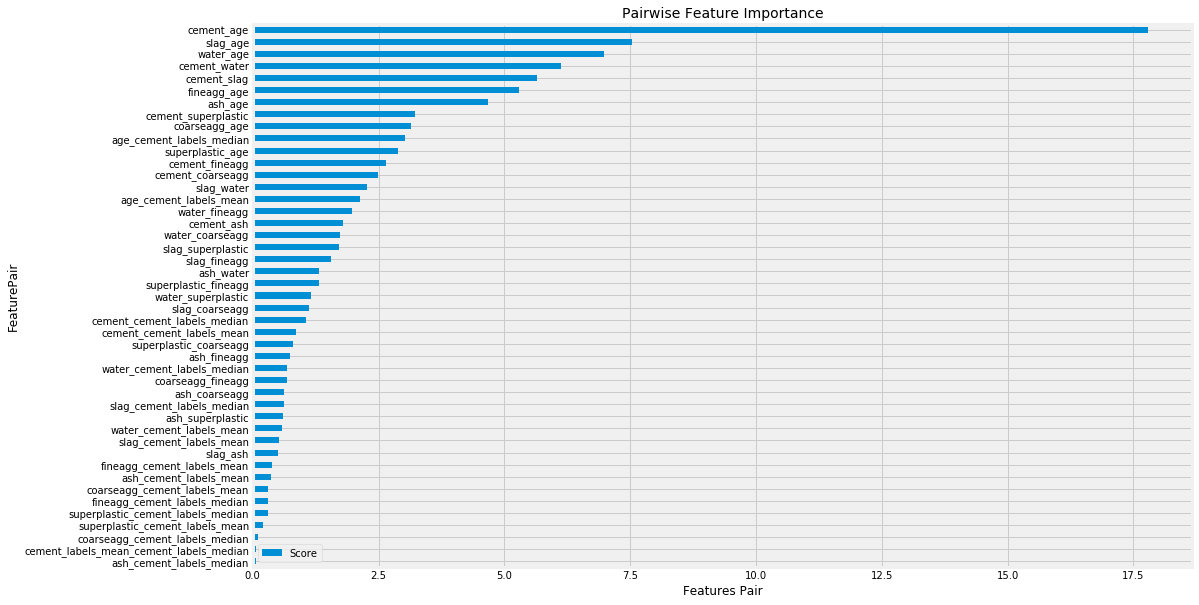

In [40]:
# Get feature importance -- Type = Interaction
print('Feature Importance plot for catboostregressor using type = Interaction'); 
print('Adding features based on cement and age; water and age can be useful'); print('--'*60)
FI = reg.get_feature_importance(Pool(X_test, label = y_test), type = 'Interaction')
FI_new = []
for k, item in enumerate(FI):  
    first = X_test.dtypes.index[FI[k][0]]
    second = X_test.dtypes.index[FI[k][1]]
    if first != second:
        FI_new.append([first + "_" + second, FI[k][2]])
feature_score = pd.DataFrame(FI_new, columns = ['FeaturePair', 'Score'])
feature_score = feature_score.sort_values(by = 'Score', ascending = True)
ax = feature_score.plot('FeaturePair', 'Score', kind = 'barh', figsize = (15, 10))
ax.set_title('Pairwise Feature Importance', fontsize = 14)
ax.set_xlabel('Features Pair')
plt.show()

<a id='feature2'></a>
### Adding features based on feature interaction
Let's add features based on cement and age; water and age interaction.

In [41]:
# Adding features based on 'feature interaction' we got from above catboostregressor
print('Adding features based on feature interaction we got from catboostregressor\'s feature importance'); print('--'*60)

cement_age = concrete_im.groupby('age', as_index = False)['cement'].agg(['mean', 'median'])
concrete_im = concrete_im.merge(cement_age, on = 'age', how = 'left')
concrete_im.rename(columns = {'mean': 'cement_age_mean', 'median': 'cement_age_median'}, inplace = True)

water_age = concrete_im.groupby('age')['water'].agg(['mean', 'median']); concrete_im = concrete_im.merge(water_age, on = 'age', how = 'left')
concrete_im.rename(columns = {'mean': 'water_age_mean', 'median': 'water_age_median'}, inplace = True)
concrete_im.describe()

Adding features based on feature interaction we got from catboostregressor's feature importance
------------------------------------------------------------------------------------------------------------------------


cement    slag     ash   water  superplastic  coarseagg  fineagg  \
count 1028.00 1028.00 1028.00 1028.00       1028.00    1028.00  1028.00   
mean   280.74   73.48   54.29  181.69          5.98     972.85   772.37   
std    104.14   85.38   64.01   20.56          5.48      77.66    78.68   
min    102.00    0.00    0.00  126.60          0.00     801.00   594.00   
25%    192.00    0.00    0.00  164.90          0.00     932.00   730.30   
50%    272.80   22.00    0.00  185.00          6.20     968.00   778.50   
75%    350.00  142.80  118.30  192.00         10.10    1029.40   822.20   
max    540.00  342.10  200.10  228.00         23.40    1145.00   945.00   

          age  strength  cement_labels_mean  cement_labels_median  \
count 1028.00   1028.00             1028.00               1028.00   
mean    33.28     35.74              280.74                274.50   
std     27.98     16.64               85.39                 81.05   
min      1.00      2.33              202.25                200.00   
25%      7.00     23.70              202.25                200.00   
50%     28.00     34.34              202.25                200.00   
75%     45.66     45.91              373.55                362.60   
max    120.00     82.60              373.55                362.60   

       cement_age_mean  cement_age_median  water_age_mean  water_age_median  
count          1028.00            1028.00         1028.00           1028.00  
mean            280.74             270.42          181.69            183.12  
std              31.43              35.00           10.52             13.74  
min             220.91             213.75          157.76            154.80  
25%             264.32             254.50          176.63            178.50  
50%             264.32             260.90          182.81            185.00  
75%             294.17             288.50          182.81            185.00  
max             442.50             442.50          210.80            228.00

<a id='featureimportance'></a>
### Feature Importance
Let's use model based feature importance, eli5, correlation matrix and absolute correlation to understand important features.

In [42]:
X = concrete_im.drop('strength', axis = 1)
y = concrete_im['strength']
features_list = list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

reg = CatBoostRegressor(iterations = None, eval_metric = 'RMSE', random_state = random_state, task_type = 'GPU', od_type = 'Iter', od_wait = 5)
reg.fit(X_train, y_train, early_stopping_rounds = 5, verbose = False, eval_set = [(X_test, y_test)], use_best_model = True)

In [43]:
# Get feature importance -- eli5
perm = PermutationImportance(reg, random_state = random_state).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Feature Importance plot for catboostregressor using type = PredictionValuesChange
Age, cement and water are top 3 importance features
------------------------------------------------------------------------------------------------------------------------


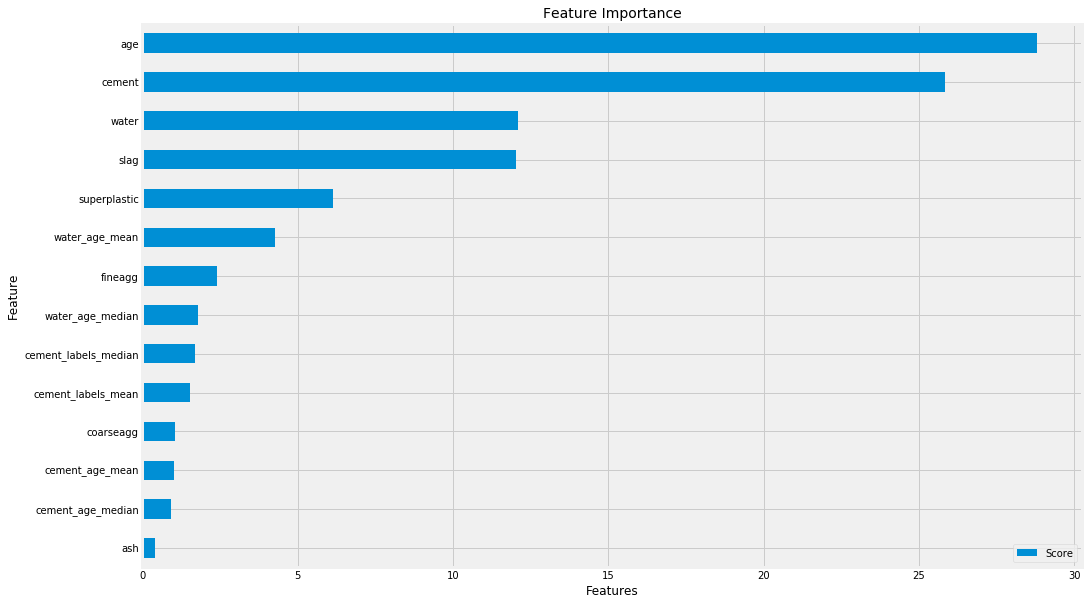

In [44]:
# Get feature importance -- model based
print('Feature Importance plot for catboostregressor using type = PredictionValuesChange'); 
print('Age, cement and water are top 3 importance features'); print('--'*60)
FI = reg.get_feature_importance(Pool(X_test, label = y_test), type = 'PredictionValuesChange')
feature_score = pd.DataFrame(list(zip(X_test.dtypes.index, FI)), columns = ['Feature', 'Score'])
feature_score = feature_score.sort_values(by = 'Score', ascending = True)
ax = feature_score.plot('Feature', 'Score', kind = 'barh', figsize = (15, 10))
ax.set_title('Feature Importance', fontsize = 14)
ax.set_xlabel('Features')
plt.show()

cement_labels_mean    cement_labels_median   1.00
cement_labels_median  cement_labels_mean     1.00
water_age_median      water_age_mean         0.95
water_age_mean        water_age_median       0.95
cement_age_median     cement_age_mean        0.91
cement_age_mean       cement_age_median      0.91
dtype: float64

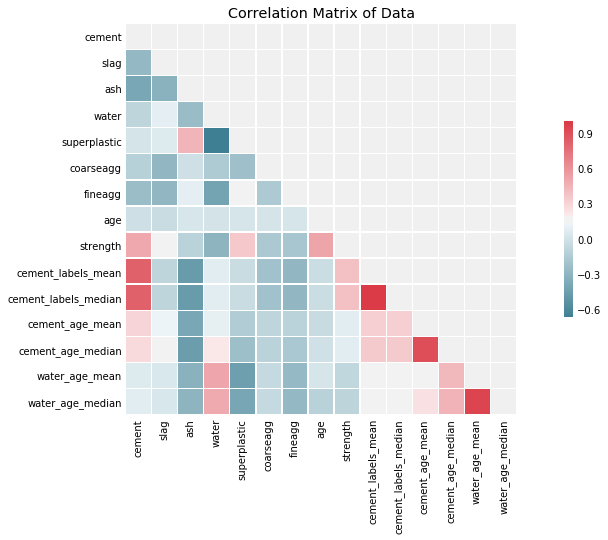

In [45]:
# Correlation matrix
correlation_matrix(concrete_im, 0.9)

In [46]:
# Absolute correlation of independent variables with the target variable
absCorrwithDep = []
allVars = concrete_im.drop('strength', axis = 1).columns

for var in allVars:
    absCorrwithDep.append(abs(concrete_im['strength'].corr(concrete_im[var])))

display(pd.DataFrame([allVars, absCorrwithDep], index = ['Variable', 'Correlation']).T.\
        sort_values('Correlation', ascending = False))

Variable Correlation
7                    age        0.52
0                 cement        0.49
9   cement_labels_median        0.40
8     cement_labels_mean        0.40
4           superplastic        0.35
3                  water        0.30
6                fineagg        0.19
5              coarseagg        0.17
1                   slag        0.14
2                    ash        0.10
13      water_age_median        0.09
10       cement_age_mean        0.08
11     cement_age_median        0.07
12        water_age_mean        0.07

In [47]:
print('Checking if multicollinearity exists')
print('A VIF between 5 and 10 indicates high correlation that may be problematic. And if the VIF goes above 10, you can assume that the regression coefficients are poorly estimated due to multicollinearity.')
print('--'*60)

y, X = dmatrices('strength ~ cement + slag + ash + water + superplastic + coarseagg + fineagg + age + cement_labels_mean + cement_labels_median + cement_age_mean + cement_age_median + water_age_mean + water_age_median', 
                 concrete_im, return_type = 'dataframe')
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['Features'] = X.columns
display(vif.round(1).sort_values(by = 'VIF Factor', ascending = False))

Checking if multicollinearity exists
A VIF between 5 and 10 indicates high correlation that may be problematic. And if the VIF goes above 10, you can assume that the regression coefficients are poorly estimated due to multicollinearity.
------------------------------------------------------------------------------------------------------------------------


VIF Factor              Features
9          inf    cement_labels_mean
10         inf  cement_labels_median
13       15.90        water_age_mean
14       15.00      water_age_median
12        9.10     cement_age_median
1         7.80                cement
11        7.80       cement_age_mean
2         5.90                  slag
7         5.60               fineagg
3         5.50                   ash
4         5.50                 water
6         4.00             coarseagg
5         3.20          superplastic
8         1.30                   age
0         0.00             Intercept

<a id='o8'></a>
#### Observation 8 - Feature Engineering
* In the feature engineering steps we identified that there clusters between cement and rest of the independent features. Used that to add features based on cement and cluster labels. Features were added for min, max, mean and median values for cement-labels group.
* Further, we also made use of CatBoostRegressor's feature interaction to add features based on cement and age; water and age interaction.
* While doing this steps, we added 6 new features. It was important to check feature importance and correlation matrix at this stage.
* `age`, `cement`, `water`, `slag` are some of the importance features based on eli5 and model based feature importance. Dropping all newly added features since they resulted in multicollinearity :(.

In [48]:
concrete_im.drop(['water_age_mean', 'water_age_median', 'cement_age_mean', 'cement_labels_mean', 'cement_labels_median', 'cement_age_mean'], axis = 1, inplace = True)
concrete_im.shape, concrete_im.columns

((1028, 10),
 Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
        'fineagg', 'age', 'strength', 'cement_age_median'],
       dtype='object'))

<a id='modelcomplexity'></a>
### Model Complexity
Decide on complexity of the model, should it be simple linear mode in terms of parameters or would a quadratic or higher degree help

In [49]:
print('Split into training (70%), validation(10%) and test(20%) sets for both with EDA and FE & without EDA and FE.')
print('--'*60)

# Training, validation and test sets with outliers
X = concrete.drop('strength', axis = 1); y = concrete['strength']; features_list = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.12, random_state = random_state)
print(f'Shape of train, valid and test datasets without EDA, FE: {(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)}')
print(f'Proportion in the splits for train, valid, test datasets without EDA, FE: {round(len(X_train)/len(X), 2), round(len(X_val)/len(X), 2), round(len(X_test)/len(X), 2)}')

# Training, validation and test sets without outliers
X = concrete_im.drop('strength', axis = 1); y = concrete_im['strength']; features_list = list(X.columns)
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X, y, test_size = 0.2, random_state = random_state)
X_train_fe, X_val_fe, y_train_fe, y_val_fe = train_test_split(X_train_fe, y_train_fe, test_size = 0.12, random_state = random_state)
print(f'\nShape of train, valid and test datasets with EDA, FE: {(X_train_fe.shape, y_train_fe.shape, X_val_fe.shape, y_val_fe.shape, X_test_fe.shape, y_test_fe.shape)}')
print(f'Proportion in the splits for train, valid, test datasets with EDA, FE: {round(len(X_train_fe)/len(X), 2), round(len(X_val_fe)/len(X), 2), round(len(X_test_fe)/len(X), 2)}')

training_test_sets = {'withoutedafe': (X_train, y_train, X_val, y_val), 'withedafe': (X_train_fe, y_train_fe, X_val_fe, y_val_fe)}

Split into training (70%), validation(10%) and test(20%) sets for both with EDA and FE & without EDA and FE.
------------------------------------------------------------------------------------------------------------------------
Shape of train, valid and test datasets without EDA, FE: ((725, 8), (725,), (99, 8), (99,), (206, 8), (206,))
Proportion in the splits for train, valid, test datasets without EDA, FE: (0.7, 0.1, 0.2)

Shape of train, valid and test datasets with EDA, FE: ((723, 9), (723,), (99, 9), (99,), (206, 9), (206,))
Proportion in the splits for train, valid, test datasets with EDA, FE: (0.7, 0.1, 0.2)


<a id='check1'></a>
### Check the improvement from dataset we had, also decide on complexity

In [50]:
print('Let\'s check cross validated scores on linear models and tree-based models on training and validation sets with and without EDA & FE')
print('--'*60)
models = []
models.append(('Linear', LinearRegression()))
models.append(('Lasso', Lasso(random_state = random_state)))
models.append(('Ridge', Ridge(random_state = random_state)))
models.append(('SVR', SVR()))
models.append(('DecisionTree', DecisionTreeRegressor(random_state = random_state)))
models.append(('GradientBoost', GradientBoostingRegressor(random_state = random_state)))
models.append(('AdaBoost', AdaBoostRegressor(random_state = random_state)))
models.append(('ExtraTrees', ExtraTreesRegressor(random_state = random_state)))
models.append(('RandomForest', RandomForestRegressor(random_state = random_state)))
models.append(('Bagging', BaggingRegressor(DecisionTreeRegressor(random_state = random_state), random_state = random_state)))
models.append(('CatBoost', CatBoostRegressor(random_state = random_state, silent = True)))

scoring = 'r2'; results = {}; score = {}

for encoding_label, (_X_train, _y_train, _X_val, _y_val) in training_test_sets.items():
  scores = []; result_cv = []; names = []
  for name, model in models:
    kf = KFold(n_splits = 10, random_state = random_state)
    cv_results = cross_val_score(model, _X_train, _y_train, cv = kf, scoring = scoring)
    result_cv.append(cv_results); names.append(name)
    scores.append([name, cv_results.mean().round(4), cv_results.std().round(4)])
  score[encoding_label] = scores
  results[encoding_label] = [names, result_cv]

print('Let\'s check the cv scores (r2) for sets without EDA and FE')
display(score['withoutedafe'])

print('\nLet\'s check the cv scores (r2) for sets with EDA and FE')
display(score['withedafe'])

Let's check cross validated scores on linear models and tree-based models on training and validation sets with and without EDA & FE
------------------------------------------------------------------------------------------------------------------------
Let's check the cv scores (r2) for sets without EDA and FE


[['Linear', 0.6111, 0.0585],
 ['Lasso', 0.6104, 0.0605],
 ['Ridge', 0.6111, 0.0585],
 ['SVR', 0.0141, 0.0222],
 ['DecisionTree', 0.7819, 0.0752],
 ['GradientBoost', 0.8955, 0.035],
 ['AdaBoost', 0.7876, 0.036],
 ['ExtraTrees', 0.8932, 0.043],
 ['RandomForest', 0.8794, 0.0378],
 ['Bagging', 0.8765, 0.0361],
 ['CatBoost', 0.9335, 0.0255]]


Let's check the cv scores (r2) for sets with EDA and FE


[['Linear', 0.7427, 0.0436],
 ['Lasso', 0.7427, 0.0435],
 ['Ridge', 0.7427, 0.0436],
 ['SVR', 0.0067, 0.0209],
 ['DecisionTree', 0.7747, 0.0874],
 ['GradientBoost', 0.9064, 0.0262],
 ['AdaBoost', 0.7864, 0.0258],
 ['ExtraTrees', 0.8953, 0.0253],
 ['RandomForest', 0.8877, 0.0251],
 ['Bagging', 0.8895, 0.0208],
 ['CatBoost', 0.9354, 0.0198]]

In [51]:
pd.options.display.float_format = "{:.4f}".format

scores_df = pd.concat([pd.DataFrame(score['withoutedafe'], columns = ['Model', 'R2 (Mean) Without', 'R2 (Std) Without']).set_index('Model'), 
           pd.DataFrame(score['withedafe'], columns = ['Model', 'R2 (Mean) With', 'R2 (Std) With']).set_index('Model')], axis = 1)
scores_df['Improvement?'] = scores_df['R2 (Mean) With'] - scores_df['R2 (Mean) Without']
display(scores_df)

R2 (Mean) Without  R2 (Std) Without  R2 (Mean) With  \
Model                                                                
Linear                    0.6111            0.0585          0.7427   
Lasso                     0.6104            0.0605          0.7427   
Ridge                     0.6111            0.0585          0.7427   
SVR                       0.0141            0.0222          0.0067   
DecisionTree              0.7819            0.0752          0.7747   
GradientBoost             0.8955            0.0350          0.9064   
AdaBoost                  0.7876            0.0360          0.7864   
ExtraTrees                0.8932            0.0430          0.8953   
RandomForest              0.8794            0.0378          0.8877   
Bagging                   0.8765            0.0361          0.8895   
CatBoost                  0.9335            0.0255          0.9354   

               R2 (Std) With  Improvement?  
Model                                       
Linear                0.0436        0.1316  
Lasso                 0.0435        0.1323  
Ridge                 0.0436        0.1316  
SVR                   0.0209       -0.0074  
DecisionTree          0.0874       -0.0072  
GradientBoost         0.0262        0.0109  
AdaBoost              0.0258       -0.0012  
ExtraTrees            0.0253        0.0021  
RandomForest          0.0251        0.0083  
Bagging               0.0208        0.0130  
CatBoost              0.0198        0.0019

A significant improvement in r2 scores after EDA & FE for linear algorithms whereas remains almost same for tree-based algorithms.
------------------------------------------------------------------------------------------------------------------------


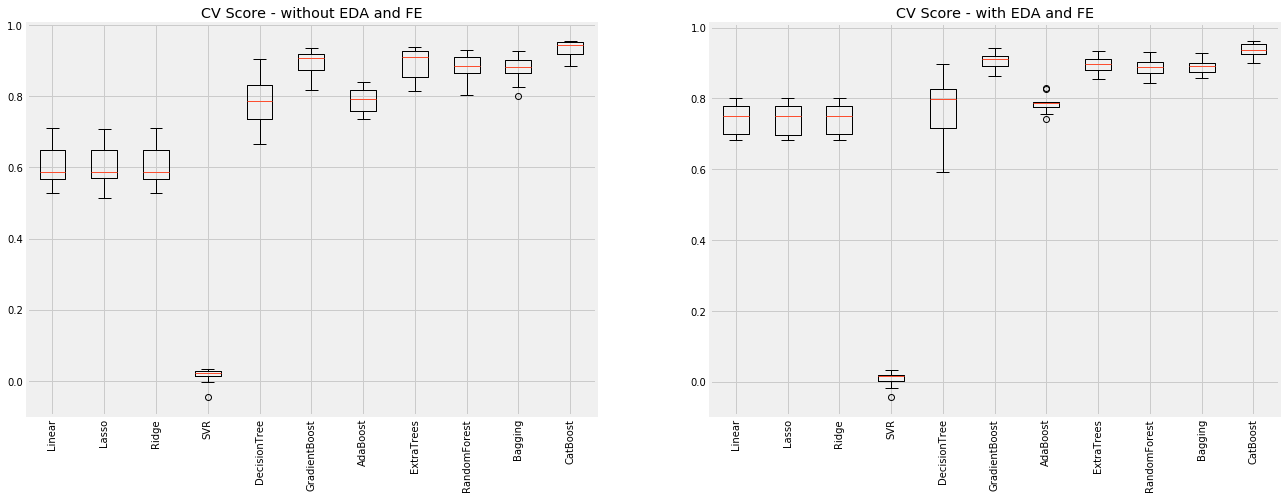

In [52]:
print('A significant improvement in r2 scores after EDA & FE for linear algorithms whereas remains almost same for tree-based algorithms.'); print('--'*60)

fig,(ax1, ax2) = plt.subplots(1, 2, figsize = (20, 7.2))
ax1.boxplot(results['withoutedafe'][1]); ax1.set_xticklabels(results['withoutedafe'][0], rotation = 90); ax1.set_title('CV Score - without EDA and FE')
ax2.boxplot(results['withedafe'][1]); ax2.set_xticklabels(results['withedafe'][0], rotation = 90); ax2.set_title('CV Score - with EDA and FE')
plt.show()

<a id='o9'></a>
#### Observation 9 - Model Complexity
* We see an improvement in the scores against the uncleaned data we had. Improvements are clearly seen for linear algos whereas for tree-based it either marginally increases/decreases.
* Tree-based algorithms are a clear choice when it comes to linear vs tree-based comparison.
* CatboostRegressor gives us the highest r2 score.

<a id='check2'></a>
### Scale or not scale?

In [0]:
scalers = {'notscaled': None, 'standardscaling': StandardScaler(), 'robustscaling': RobustScaler()}

training_test_sets = {'validation_sets': (X_train_fe, y_train_fe, X_val_fe, y_val_fe),
                      'test_sets': (X_train_fe, y_train_fe, X_test_fe, y_test_fe)}

# initialize model
cat_reg = CatBoostRegressor(iterations = None, eval_metric = 'RMSE', random_state = random_state, od_type = 'Iter', od_wait = 5)

# iterate over all possible combinations and get the errors
errors = {}
for encoding_label, (_X_train, _y_train, _X_val, _y_val) in training_test_sets.items():
    for scaler_label, scaler in scalers.items():
        scores = []
        if scaler == None:
          trainingset = _X_train.copy()
          testset = _X_val.copy()
          cat_reg.fit(trainingset, _y_train, early_stopping_rounds = 5, verbose = False, plot = False,
                      eval_set = [(testset, _y_val)], use_best_model = True)
          pred = cat_reg.predict(testset)
          rmse = rmse_score(_y_val, pred)
          r2 = r2_score(_y_val, pred)
          scores.append([rmse, r2])
          key = encoding_label + ' - ' + scaler_label
          errors[key] = scores[0]
        else:
          trainingset = _X_train.copy()
          testset = _X_val.copy()
          trainingset = scaler.fit_transform(trainingset)
          testset = scaler.transform(testset)
          cat_reg.fit(trainingset, _y_train, early_stopping_rounds = 5, verbose = False, plot = False,
                      eval_set = [(testset, _y_val)], use_best_model = True)
          pred = cat_reg.predict(testset)
          rmse = rmse_score(_y_val, pred)
          r2 = r2_score(_y_val, pred)
          scores.append([rmse, r2])
          key = encoding_label + ' - ' + scaler_label
          errors[key] = scores[0]

In [54]:
print('It can be seen that RMSE is lowest when robust scaling is used whereas R2 almost remains same as un-scaled data.'); 
print('Scaling would help to effectively use the training and validation sets across algorithms.');print('--'*60)

display(errors)

It can be seen that RMSE is lowest when robust scaling is used whereas R2 almost remains same as un-scaled data.
Scaling would help to effectively use the training and validation sets across algorithms.
------------------------------------------------------------------------------------------------------------------------


{'test_sets - notscaled': [5.017740715374914, 0.9029477226511713],
 'test_sets - robustscaling': [5.016708291568481, 0.9029876564696246],
 'test_sets - standardscaling': [5.017740715374914, 0.9029477226511713],
 'validation_sets - notscaled': [3.635744907606918, 0.9505996967830845],
 'validation_sets - robustscaling': [3.6357200661797204, 0.9506003718413599],
 'validation_sets - standardscaling': [3.6357200661797204, 0.9506003718413599]}

<a id='o10'></a>
#### Observation 10 - Yes, scale please
* It can be seen that RMSE is lowest when robust scaling is used, whereas R2 score remains almost same as unscaled data. Additionally, scaling would also help to effectively use the training and validation sets across algos.

<a id='Model'></a>
## Modelling
* Choose an algorithm. Here we would choose/evaluate, 3 linears and 2 decision tree based + AdaBoost, GradientBoost and ExtraTrees regressors. +Bonus: CatBoostRegressor.
* Employ hyperparameter tuning techniques to squeeze that extra performance out of the model without making it overfit or underfit
* Model performance range at 95% confidence level

In [0]:
## Helper function to train, validate and predict
def train_val_predict(basemodel, train_X, train_y, test_X, test_y, name, model):

  folds = list(KFold(n_splits = 5, random_state = random_state, shuffle = True).split(train_X, train_y))
  
  r2_scores_train = []; r2_scores_val = []; r2_scores_test = []

  for j, (train_index, val_index) in enumerate(folds):
    X_train = train_X.iloc[train_index]
    y_train = train_y.iloc[train_index]
    X_val = train_X.iloc[val_index]
    y_val = train_y.iloc[val_index]

    if model == 'CatBoost':
      basemodel.fit(X_train, y_train, early_stopping_rounds = 5, verbose = 300, eval_set = [(X_val, y_val)], use_best_model = True)
    else:
      basemodel.fit(X_train, y_train)

    pred = basemodel.predict(X_train)
    r2 = r2_score(y_train, pred); r2_scores_train.append(r2)
    
    pred = basemodel.predict(X_val)
    r2 = r2_score(y_val, pred); r2_scores_val.append(r2)

    pred = basemodel.predict(X_test_fe)
    r2 = r2_score(y_test_fe, pred); r2_scores_test.append(r2)

  df = pd.DataFrame([np.mean(r2_scores_train), np.mean(r2_scores_val), np.mean(r2_scores_test)],
                    index = ['r2 Scores Train', 'r2 Scores Val', 'r2 Scores Test'], 
                    columns = [name]).T
  return df

In [56]:
print('Separating the dependents and independents + Scaling the data'); print('--'*60)
features_list = list(concrete_im.columns)
concrete_im = concrete_im.apply(zscore); concrete_im = pd.DataFrame(concrete_im , columns = features_list)
display(concrete_im.describe())

X = concrete_im.drop('strength', axis = 1); y = concrete_im['strength']; 
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X, y, test_size = 0.2, random_state = random_state)

X_train_fe.shape, X_test_fe.shape, y_train_fe.shape, y_test_fe.shape

Separating the dependents and independents + Scaling the data
------------------------------------------------------------------------------------------------------------------------


cement      slag       ash     water  superplastic  coarseagg  \
count 1028.0000 1028.0000 1028.0000 1028.0000     1028.0000  1028.0000   
mean    -0.0000    0.0000    0.0000   -0.0000        0.0000     0.0000   
std      1.0005    1.0005    1.0005    1.0005        1.0005     1.0005   
min     -1.7171   -0.8611   -0.8486   -2.6808       -1.0932    -2.2140   
25%     -0.8525   -0.8611   -0.8486   -0.8171       -1.0932    -0.5263   
50%     -0.0762   -0.6033   -0.8486    0.1609        0.0404    -0.0625   
75%      0.6654    0.8123    1.0004    0.5016        0.7521     0.7285   
max      2.4907    3.1478    2.2788    2.2533        3.1821     2.2179   

        fineagg       age  strength  cement_age_median  
count 1028.0000 1028.0000 1028.0000          1028.0000  
mean    -0.0000    0.0000    0.0000            -0.0000  
std      1.0005    1.0005    1.0005             1.0005  
min     -2.2682   -1.1543   -2.0092            -1.6196  
25%     -0.5350   -0.9397   -0.7244            -0.4549  
50%      0.0779   -0.1888   -0.0842            -0.2720  
75%      0.6336    0.4428    0.6112             0.5169  
max      2.1952    3.1012    2.8174             4.9185

((822, 9), (206, 9), (822,), (206,))

<a id='Linear'></a>
### Linear Regression, Lasso, Ridge

In [57]:
print('Using the 5-Fold Linear Regression to train, validate and predict'); print('--'*60)
lr_reg = LinearRegression()
df_lr = train_val_predict(lr_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold LinearRegression', model = 'LR')

Using the 5-Fold Linear Regression to train, validate and predict
------------------------------------------------------------------------------------------------------------------------


In [58]:
%%time
print('Using the 5-Fold Lasso Regression to train, validate and predict'); print('--'*60)
lasso_reg = Lasso(alpha = 0.01)
df_lasso = train_val_predict(lasso_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold LassoRegression', model = 'Lasso')
df = df_lr.append(df_lasso)

Using the 5-Fold Lasso Regression to train, validate and predict
------------------------------------------------------------------------------------------------------------------------
CPU times: user 44 ms, sys: 1.09 ms, total: 45.1 ms
Wall time: 46.3 ms


In [59]:
%%time
print('Using the 5-Fold Ridge Regression to train, validate and predict'); print('--'*60)
ridge_reg = Ridge(alpha = 0.01)
df_ridge = train_val_predict(ridge_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold RidgeRegression', model = 'Ridge')
df = df.append(df_ridge)
display(df)

Using the 5-Fold Ridge Regression to train, validate and predict
------------------------------------------------------------------------------------------------------------------------


r2 Scores Train  r2 Scores Val  r2 Scores Test
5-Fold LinearRegression           0.7600         0.7504          0.6671
5-Fold LassoRegression            0.7587         0.7498          0.6653
5-Fold RidgeRegression            0.7600         0.7504          0.6671

CPU times: user 43.6 ms, sys: 3.93 ms, total: 47.6 ms
Wall time: 48.8 ms


<a id='Tree'></a>
### Decision Tree and Random Forest

In [60]:
%%time
print('Finding out the hyperparameters for Decision Tree and Random Forest with GridSearchCV'); print('--'*60)
best_params_grid = {}

# Decision Tree and Random Forest Regressor Hyperparameters Grid
param_grid = {'DecisionTree': {'criterion': ['mse', 'mae'], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None]},
              'RandomForest': {'bootstrap': [True, False], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                                'max_features': ['auto', 'sqrt'], 'n_estimators': [200, 400, 600, 800]}}

# Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state = random_state)
dt_reg_grid = GridSearchCV(dt_reg, param_grid['DecisionTree'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
dt_reg_grid.fit(X_train_fe, y_train_fe)
best_params_grid['DecisionTree'] = dt_reg_grid.best_params_

# Random Forest Regressor
rf_reg = RandomForestRegressor(random_state = random_state)
rf_reg_grid = GridSearchCV(rf_reg, param_grid['RandomForest'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
rf_reg_grid.fit(X_train_fe, y_train_fe)
best_params_grid['RandomForest'] = rf_reg_grid.best_params_

print(f'Best parameters for Decision Tree and Random Forest using GridSearchCV: {best_params_grid}')

Finding out the hyperparameters for Decision Tree and Random Forest with GridSearchCV
------------------------------------------------------------------------------------------------------------------------
Best parameters for Decision Tree and Random Forest using GridSearchCV: {'DecisionTree': {'criterion': 'mse', 'max_depth': None}, 'RandomForest': {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'n_estimators': 800}}
CPU times: user 7.7 s, sys: 460 ms, total: 8.16 s
Wall time: 11min 54s


In [61]:
%%time
print('Finding out the hyperparameters for Decision Tree and Random Forest with RandomizedSearchCV'); print('--'*60)
best_params_random = {}

# Decision Tree and Random Forest Regressor Hyperparameters Grid
param_grid = {'DecisionTree': {'criterion': ['mse', 'mae'], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None]},
              'RandomForest': {'bootstrap': [True, False], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                                'max_features': ['auto', 'sqrt'], 'n_estimators': [200, 400, 600, 800]}}

# Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state = random_state)
dt_reg_grid = RandomizedSearchCV(dt_reg, param_grid['DecisionTree'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
dt_reg_grid.fit(X_train_fe, y_train_fe)
best_params_random['DecisionTree'] = dt_reg_grid.best_params_

# Random Forest Regressor
rf_reg = RandomForestRegressor(random_state = random_state)
rf_reg_grid = RandomizedSearchCV(rf_reg, param_grid['RandomForest'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
rf_reg_grid.fit(X_train_fe, y_train_fe)
best_params_random['RandomForest'] = rf_reg_grid.best_params_

print(f'Best parameters for Decision Tree and Random Forest using RandomizedSearchCV: {best_params_random}')

Finding out the hyperparameters for Decision Tree and Random Forest with RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------------
Best parameters for Decision Tree and Random Forest using RandomizedSearchCV: {'DecisionTree': {'max_depth': None, 'criterion': 'mse'}, 'RandomForest': {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}}
CPU times: user 912 ms, sys: 114 ms, total: 1.03 s
Wall time: 59.4 s


In [62]:
%%time
print('Using the 5-Fold Decision Tree Regressor to train, validate and predict'); print('--'*60)
dt_reg = DecisionTreeRegressor(random_state = random_state)
df_reg = train_val_predict(dt_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold DecisionTree', model = 'DT')
df = df.append(df_reg)

Using the 5-Fold Decision Tree Regressor to train, validate and predict
------------------------------------------------------------------------------------------------------------------------
CPU times: user 51.2 ms, sys: 2.86 ms, total: 54 ms
Wall time: 56.3 ms


In [63]:
%%time
print('Using the 5-Fold Decision Tree Regressor to train, validate and predict using GridSearchCV'); print('--'*60)
dt_reg_grid = DecisionTreeRegressor(random_state = random_state, **best_params_grid['DecisionTree'])
df_reg_grid = train_val_predict(dt_reg_grid, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold DecisionTree GridSearchCV', model = 'DT')
df = df.append(df_reg_grid)

Using the 5-Fold Decision Tree Regressor to train, validate and predict using GridSearchCV
------------------------------------------------------------------------------------------------------------------------
CPU times: user 55.6 ms, sys: 1 ms, total: 56.6 ms
Wall time: 60.9 ms


In [64]:
%%time
print('Using the 5-Fold Decision Tree Regressor to train, validate and predict using RandomizedSearchCV'); print('--'*60)
dt_reg_rand = DecisionTreeRegressor(random_state = random_state, **best_params_random['DecisionTree'])
df_reg_rand = train_val_predict(dt_reg_rand, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold DecisionTree RandomizedSearchCV', model = 'DT')
df = df.append(df_reg_rand)
display(df)

Using the 5-Fold Decision Tree Regressor to train, validate and predict using RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------------


r2 Scores Train  r2 Scores Val  \
5-Fold LinearRegression                          0.7600         0.7504   
5-Fold LassoRegression                           0.7587         0.7498   
5-Fold RidgeRegression                           0.7600         0.7504   
5-Fold DecisionTree                              0.9991         0.8459   
5-Fold DecisionTree GridSearchCV                 0.9991         0.8459   
5-Fold DecisionTree RandomizedSearchCV           0.9991         0.8459   

                                        r2 Scores Test  
5-Fold LinearRegression                         0.6671  
5-Fold LassoRegression                          0.6653  
5-Fold RidgeRegression                          0.6671  
5-Fold DecisionTree                             0.8014  
5-Fold DecisionTree GridSearchCV                0.8014  
5-Fold DecisionTree RandomizedSearchCV          0.8014

CPU times: user 60.2 ms, sys: 1.7 ms, total: 61.9 ms
Wall time: 60.1 ms


In [65]:
%%time
print('Using the 5-Fold Random Forest Regressor to train, validate and predict'); print('--'*60)
rf_reg = RandomForestRegressor(random_state = random_state)
df_reg = train_val_predict(rf_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold RandomForest', model = 'RF')
df = df.append(df_reg)

Using the 5-Fold Random Forest Regressor to train, validate and predict
------------------------------------------------------------------------------------------------------------------------
CPU times: user 219 ms, sys: 2.76 ms, total: 222 ms
Wall time: 221 ms


In [66]:
%%time
print('Using the 5-Fold Random Forest Regressor to train, validate and predict using GridSearchCV'); print('--'*60)
rf_reg_grid = RandomForestRegressor(random_state = random_state, **best_params_grid['RandomForest'])
df_reg_grid = train_val_predict(rf_reg_grid, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold RandomForest GridSearchCV', model = 'RF')
df = df.append(df_reg_grid)

Using the 5-Fold Random Forest Regressor to train, validate and predict using GridSearchCV
------------------------------------------------------------------------------------------------------------------------
CPU times: user 14 s, sys: 36.7 ms, total: 14.1 s
Wall time: 14.1 s


In [67]:
%%time
print('Using the 5-Fold Random Forest Regressor to train, validate and predict using RandomizedSearchCV'); print('--'*60)
rf_reg_rand = RandomForestRegressor(random_state = random_state, **best_params_random['RandomForest'])
df_reg_rand = train_val_predict(rf_reg_rand, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold RandomForest RandomizedSearchCV', model = 'RF')
df = df.append(df_reg_rand)
display(df)

Using the 5-Fold Random Forest Regressor to train, validate and predict using RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------------


r2 Scores Train  r2 Scores Val  \
5-Fold LinearRegression                          0.7600         0.7504   
5-Fold LassoRegression                           0.7587         0.7498   
5-Fold RidgeRegression                           0.7600         0.7504   
5-Fold DecisionTree                              0.9991         0.8459   
5-Fold DecisionTree GridSearchCV                 0.9991         0.8459   
5-Fold DecisionTree RandomizedSearchCV           0.9991         0.8459   
5-Fold RandomForest                              0.9771         0.8858   
5-Fold RandomForest GridSearchCV                 0.9867         0.9039   
5-Fold RandomForest RandomizedSearchCV           0.9857         0.9001   

                                        r2 Scores Test  
5-Fold LinearRegression                         0.6671  
5-Fold LassoRegression                          0.6653  
5-Fold RidgeRegression                          0.6671  
5-Fold DecisionTree                             0.8014  
5-Fold DecisionTree GridSearchCV                0.8014  
5-Fold DecisionTree RandomizedSearchCV          0.8014  
5-Fold RandomForest                             0.8667  
5-Fold RandomForest GridSearchCV                0.8776  
5-Fold RandomForest RandomizedSearchCV          0.8736

CPU times: user 2.48 s, sys: 14 ms, total: 2.49 s
Wall time: 2.5 s


<a id='EnsembleTree'></a>
### AdaBoost, GradientBoost and ExtraTrees

In [68]:
%%time
print('Using the 5-Fold Ada Boost Regressor to train, validate and predict'); print('--'*60)
ada_reg = AdaBoostRegressor(random_state = random_state)
df_reg = train_val_predict(ada_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold AdaBoost', model = 'Ada')
df = df.append(df_reg)

Using the 5-Fold Ada Boost Regressor to train, validate and predict
------------------------------------------------------------------------------------------------------------------------
CPU times: user 627 ms, sys: 2.35 ms, total: 629 ms
Wall time: 635 ms


In [69]:
%%time
# AdaBoost Regressor Hyperparameters Grid
print('Finding out the hyperparameters for AdaBoostRegressor with GridSearchCV'); print('--'*60)

param_grid = {'AdaBoost': {'base_estimator': [DecisionTreeRegressor(random_state = random_state, **best_params_grid['DecisionTree']), None],
                           'n_estimators': [100, 150, 200], 'learning_rate': [0.01, 0.1, 1.0]}}

# AdaBoost Regressor
ada_reg = AdaBoostRegressor(random_state = random_state)
ada_reg_grid = GridSearchCV(ada_reg, param_grid['AdaBoost'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
ada_reg_grid.fit(X_train_fe, y_train_fe)
best_params_grid['AdaBoost'] = ada_reg_grid.best_params_

print('Best parameters for AdaBoost Regressor using GridSearchCV: {}'.format(best_params_grid['AdaBoost']))

Finding out the hyperparameters for AdaBoostRegressor with GridSearchCV
------------------------------------------------------------------------------------------------------------------------
Best parameters for AdaBoost Regressor using GridSearchCV: {'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=2019, splitter='best'), 'learning_rate': 1.0, 'n_estimators': 100}
CPU times: user 804 ms, sys: 63.6 ms, total: 867 ms
Wall time: 34.3 s


In [70]:
%%time
# AdaBoost Regressor Hyperparameters Grid
print('Finding out the hyperparameters for AdaBoostRegressor with RandomizedSearchCV'); print('--'*60)

param_grid = {'AdaBoost': {'base_estimator': [DecisionTreeRegressor(random_state = random_state, **best_params_grid['DecisionTree']), None],
                           'n_estimators': [100, 150, 200], 'learning_rate': [0.01, 0.1, 1.0]}}

# AdaBoost Regressor
ada_reg = AdaBoostRegressor(random_state = random_state)
ada_reg_grid = RandomizedSearchCV(ada_reg, param_grid['AdaBoost'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
ada_reg_grid.fit(X_train_fe, y_train_fe)
best_params_random['AdaBoost'] = ada_reg_grid.best_params_

print('Best parameters for AdaBoost Regressor using RandomizedSearchCV: {}'.format(best_params_random['AdaBoost']))

Finding out the hyperparameters for AdaBoostRegressor with RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------------
Best parameters for AdaBoost Regressor using RandomizedSearchCV: {'n_estimators': 150, 'learning_rate': 1.0, 'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=2019, splitter='best')}
CPU times: user 715 ms, sys: 52.7 ms, total: 768 ms
Wall time: 20 s


In [71]:
%%time
print('Using the 5-Fold Ada Boost Regressor to train, validate and predict using GridSearchCV'); print('--'*60)
ada_reg_grid = AdaBoostRegressor(random_state = random_state, **best_params_grid['AdaBoost'])
df_reg_grid = train_val_predict(ada_reg_grid, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold AdaBoost using GridSearchCV', model = 'Ada')
df = df.append(df_reg_grid)

Using the 5-Fold Ada Boost Regressor to train, validate and predict using GridSearchCV
------------------------------------------------------------------------------------------------------------------------
CPU times: user 1.8 s, sys: 6.69 ms, total: 1.81 s
Wall time: 1.82 s


In [72]:
%%time
print('Using the 5-Fold Ada Boost Regressor to train, validate and predict using RandomizedSearchCV'); print('--'*60)
ada_reg_rand = AdaBoostRegressor(random_state = random_state, **best_params_random['AdaBoost'])
df_reg_rand = train_val_predict(ada_reg_rand, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold AdaBoost using RandomizedSearchCV', model = 'Ada')
df = df.append(df_reg_rand)
display(df)

Using the 5-Fold Ada Boost Regressor to train, validate and predict using RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------------


r2 Scores Train  r2 Scores Val  \
5-Fold LinearRegression                            0.7600         0.7504   
5-Fold LassoRegression                             0.7587         0.7498   
5-Fold RidgeRegression                             0.7600         0.7504   
5-Fold DecisionTree                                0.9991         0.8459   
5-Fold DecisionTree GridSearchCV                   0.9991         0.8459   
5-Fold DecisionTree RandomizedSearchCV             0.9991         0.8459   
5-Fold RandomForest                                0.9771         0.8858   
5-Fold RandomForest GridSearchCV                   0.9867         0.9039   
5-Fold RandomForest RandomizedSearchCV             0.9857         0.9001   
5-Fold AdaBoost                                    0.8351         0.7922   
5-Fold AdaBoost using GridSearchCV                 0.9970         0.9071   
5-Fold AdaBoost using RandomizedSearchCV           0.9966         0.9085   

                                          r2 Scores Test  
5-Fold LinearRegression                           0.6671  
5-Fold LassoRegression                            0.6653  
5-Fold RidgeRegression                            0.6671  
5-Fold DecisionTree                               0.8014  
5-Fold DecisionTree GridSearchCV                  0.8014  
5-Fold DecisionTree RandomizedSearchCV            0.8014  
5-Fold RandomForest                               0.8667  
5-Fold RandomForest GridSearchCV                  0.8776  
5-Fold RandomForest RandomizedSearchCV            0.8736  
5-Fold AdaBoost                                   0.7504  
5-Fold AdaBoost using GridSearchCV                0.8658  
5-Fold AdaBoost using RandomizedSearchCV          0.8655

CPU times: user 2.56 s, sys: 11.2 ms, total: 2.57 s
Wall time: 2.57 s


In [73]:
%%time
# GradientBoostRegressor Hyperparameters Grid
print('Finding out the hyperparameters for GradientBoostRegressor with GridSearchCV'); print('--'*60)

param_grid = {'GradientBoost': {'max_depth': [5, 6, 7, 8, 9, 10, None], 'max_features': ['auto', 'sqrt'], 
                                'n_estimators': [600, 800, 1000]}}

# GradientBoostRegressor
gb_reg = GradientBoostingRegressor(random_state = random_state)
gb_reg_grid = GridSearchCV(gb_reg, param_grid['GradientBoost'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
gb_reg_grid.fit(X_train_fe, y_train_fe)
best_params_grid['GradientBoost'] = gb_reg_grid.best_params_

print('Best parameters for Gradient Boost Regressor using GridSearchCV: {}'.format(best_params_grid['GradientBoost']))

Finding out the hyperparameters for GradientBoostRegressor with GridSearchCV
------------------------------------------------------------------------------------------------------------------------
Best parameters for Gradient Boost Regressor using GridSearchCV: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 600}
CPU times: user 1.56 s, sys: 98.4 ms, total: 1.66 s
Wall time: 2min 25s


In [74]:
%%time
# GradientBoostRegressor Hyperparameters Grid
print('Finding out the hyperparameters for GradientBoostRegressor with RandomizedSearchCV'); print('--'*60)

param_grid = {'GradientBoost': {'max_depth': [5, 6, 7, 8, 9, 10, None], 'max_features': ['auto', 'sqrt'], 
                                'n_estimators': [600, 800, 1000]}}

# GradientBoostRegressor
gb_reg = GradientBoostingRegressor(random_state = random_state)
gb_reg_rand = RandomizedSearchCV(gb_reg, param_grid['GradientBoost'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
gb_reg_rand.fit(X_train_fe, y_train_fe)
best_params_random['GradientBoost'] = gb_reg_rand.best_params_

print('Best parameters for Gradient Boost Regressor using RandomizedSearchCV: {}'.format(best_params_random['GradientBoost']))

Finding out the hyperparameters for GradientBoostRegressor with RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------------
Best parameters for Gradient Boost Regressor using RandomizedSearchCV: {'n_estimators': 600, 'max_features': 'sqrt', 'max_depth': 5}
CPU times: user 654 ms, sys: 49.8 ms, total: 704 ms
Wall time: 26.5 s


In [75]:
%%time
print('Using the 5-Fold Gradient Boost Regressor to train, validate and predict'); print('--'*60)
gb_reg = GradientBoostingRegressor(random_state = random_state)
df_reg = train_val_predict(gb_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold GradientBoost', model = 'GB')
df = df.append(df_reg)

Using the 5-Fold Gradient Boost Regressor to train, validate and predict
------------------------------------------------------------------------------------------------------------------------
CPU times: user 339 ms, sys: 0 ns, total: 339 ms
Wall time: 341 ms


In [76]:
%%time
print('Using the 5-Fold Gradient Boost Regressor to train, validate and predict using GridSearchCV'); print('--'*60)
gb_reg_grid = GradientBoostingRegressor(random_state = random_state, **best_params_grid['GradientBoost'])
df_reg_grid = train_val_predict(gb_reg_grid, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold GradientBoost using GridSearchCV', model = 'GB')
df = df.append(df_reg_grid)

Using the 5-Fold Gradient Boost Regressor to train, validate and predict using GridSearchCV
------------------------------------------------------------------------------------------------------------------------
CPU times: user 1.74 s, sys: 5.58 ms, total: 1.75 s
Wall time: 1.76 s


In [77]:
%%time
print('Using the 5-Fold Gradient Boost Regressor to train, validate and predict using RandomizedSearchCV'); print('--'*60)
gb_reg_rand = GradientBoostingRegressor(random_state = random_state, **best_params_random['GradientBoost'])
df_reg_rand = train_val_predict(gb_reg_rand, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold GradientBoost using RandomizedSearchCV', model = 'GB')
df = df.append(df_reg_rand)
display(df)

Using the 5-Fold Gradient Boost Regressor to train, validate and predict using RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------------


r2 Scores Train  r2 Scores Val  \
5-Fold LinearRegression                                 0.7600         0.7504   
5-Fold LassoRegression                                  0.7587         0.7498   
5-Fold RidgeRegression                                  0.7600         0.7504   
5-Fold DecisionTree                                     0.9991         0.8459   
5-Fold DecisionTree GridSearchCV                        0.9991         0.8459   
5-Fold DecisionTree RandomizedSearchCV                  0.9991         0.8459   
5-Fold RandomForest                                     0.9771         0.8858   
5-Fold RandomForest GridSearchCV                        0.9867         0.9039   
5-Fold RandomForest RandomizedSearchCV                  0.9857         0.9001   
5-Fold AdaBoost                                         0.8351         0.7922   
5-Fold AdaBoost using GridSearchCV                      0.9970         0.9071   
5-Fold AdaBoost using RandomizedSearchCV                0.9966         0.9085   
5-Fold GradientBoost                                    0.9564         0.9019   
5-Fold GradientBoost using GridSearchCV                 0.9990         0.9307   
5-Fold GradientBoost using RandomizedSearchCV           0.9990         0.9307   

                                               r2 Scores Test  
5-Fold LinearRegression                                0.6671  
5-Fold LassoRegression                                 0.6653  
5-Fold RidgeRegression                                 0.6671  
5-Fold DecisionTree                                    0.8014  
5-Fold DecisionTree GridSearchCV                       0.8014  
5-Fold DecisionTree RandomizedSearchCV                 0.8014  
5-Fold RandomForest                                    0.8667  
5-Fold RandomForest GridSearchCV                       0.8776  
5-Fold RandomForest RandomizedSearchCV                 0.8736  
5-Fold AdaBoost                                        0.7504  
5-Fold AdaBoost using GridSearchCV                     0.8658  
5-Fold AdaBoost using RandomizedSearchCV               0.8655  
5-Fold GradientBoost                                   0.8671  
5-Fold GradientBoost using GridSearchCV                0.8994  
5-Fold GradientBoost using RandomizedSearchCV          0.8994

CPU times: user 1.76 s, sys: 4.47 ms, total: 1.76 s
Wall time: 1.76 s


In [78]:
%%time
# ExtraTreesRegressor Hyperparameters Grid
print('Finding out the hyperparameters for ExtraTreesRegressor with GridSearchCV'); print('--'*60)

param_grid = {'ExtraTrees': {'max_depth': [5, 6, 7, 8, 9, 10, None], 'max_features': ['auto', 'sqrt'], 
                                'n_estimators': [100, 600, 800, 1000]}}

# ExtraTreesRegressor
et_reg = ExtraTreesRegressor(random_state = random_state)
et_reg_grid = GridSearchCV(et_reg, param_grid['ExtraTrees'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
et_reg_grid.fit(X_train_fe, y_train_fe)
best_params_grid['ExtraTrees'] = et_reg_grid.best_params_

print('Best parameters for Extra Trees Regressor using GridSearchCV: {}'.format(best_params_grid['ExtraTrees']))

Finding out the hyperparameters for ExtraTreesRegressor with GridSearchCV
------------------------------------------------------------------------------------------------------------------------
Best parameters for Extra Trees Regressor using GridSearchCV: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 1000}
CPU times: user 3.86 s, sys: 239 ms, total: 4.1 s
Wall time: 3min 33s


In [79]:
%%time
# ExtraTreesRegressor Hyperparameters Grid
print('Finding out the hyperparameters for ExtraTreesRegressor with RandomizedSearchCV'); print('--'*60)

param_grid = {'ExtraTrees': {'max_depth': [5, 6, 7, 8, 9, 10, None], 'max_features': ['auto', 'sqrt'], 
                                'n_estimators': [100, 600, 800, 1000]}}

# ExtraTreesRegressor
et_reg = ExtraTreesRegressor(random_state = random_state)
et_reg_rand = RandomizedSearchCV(et_reg, param_grid['ExtraTrees'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
et_reg_rand.fit(X_train_fe, y_train_fe)
best_params_random['ExtraTrees'] = et_reg_rand.best_params_

print('Best parameters for Extra Trees Regressor using RandomizedSearchCV: {}'.format(best_params_random['ExtraTrees']))

Finding out the hyperparameters for ExtraTreesRegressor with RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------------
Best parameters for Extra Trees Regressor using RandomizedSearchCV: {'n_estimators': 600, 'max_features': 'auto', 'max_depth': None}
CPU times: user 1.63 s, sys: 84.9 ms, total: 1.71 s
Wall time: 38.7 s


In [80]:
%%time
print('Using the 5-Fold Extra Trees Regressor to train, validate and predict'); print('--'*60)
et_reg = ExtraTreesRegressor(random_state = random_state)
df_reg = train_val_predict(et_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold ExtraTrees', model = 'ET')
df = df.append(df_reg)

Using the 5-Fold Extra Trees Regressor to train, validate and predict
------------------------------------------------------------------------------------------------------------------------
CPU times: user 163 ms, sys: 1.85 ms, total: 165 ms
Wall time: 165 ms


In [81]:
%%time
print('Using the 5-Fold Extra Trees Regressor to train, validate and predict using GridSearchCV'); print('--'*60)
et_reg_grid = ExtraTreesRegressor(random_state = random_state, **best_params_grid['ExtraTrees'])
df_reg_grid = train_val_predict(et_reg_grid, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold ExtraTrees using GridSearchCV', model = 'ET')
df = df.append(df_reg_grid)

Using the 5-Fold Extra Trees Regressor to train, validate and predict using GridSearchCV
------------------------------------------------------------------------------------------------------------------------
CPU times: user 12.5 s, sys: 135 ms, total: 12.6 s
Wall time: 12.6 s


In [82]:
%%time
print('Using the 5-Fold Extra Trees Regressor to train, validate and predict using RandomizedSearchCV'); print('--'*60)
et_reg_rand = ExtraTreesRegressor(random_state = random_state, **best_params_random['ExtraTrees'])
df_reg_rand = train_val_predict(et_reg_rand, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold ExtraTrees using RandomizedSearchCV', model = 'ET')
df = df.append(df_reg_rand)
display(df)

Using the 5-Fold Extra Trees Regressor to train, validate and predict using RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------------


r2 Scores Train  r2 Scores Val  \
5-Fold LinearRegression                                 0.7600         0.7504   
5-Fold LassoRegression                                  0.7587         0.7498   
5-Fold RidgeRegression                                  0.7600         0.7504   
5-Fold DecisionTree                                     0.9991         0.8459   
5-Fold DecisionTree GridSearchCV                        0.9991         0.8459   
5-Fold DecisionTree RandomizedSearchCV                  0.9991         0.8459   
5-Fold RandomForest                                     0.9771         0.8858   
5-Fold RandomForest GridSearchCV                        0.9867         0.9039   
5-Fold RandomForest RandomizedSearchCV                  0.9857         0.9001   
5-Fold AdaBoost                                         0.8351         0.7922   
5-Fold AdaBoost using GridSearchCV                      0.9970         0.9071   
5-Fold AdaBoost using RandomizedSearchCV                0.9966         0.9085   
5-Fold GradientBoost                                    0.9564         0.9019   
5-Fold GradientBoost using GridSearchCV                 0.9990         0.9307   
5-Fold GradientBoost using RandomizedSearchCV           0.9990         0.9307   
5-Fold ExtraTrees                                       0.9991         0.8918   
5-Fold ExtraTrees using GridSearchCV                    0.9991         0.9134   
5-Fold ExtraTrees using RandomizedSearchCV              0.9991         0.9135   

                                               r2 Scores Test  
5-Fold LinearRegression                                0.6671  
5-Fold LassoRegression                                 0.6653  
5-Fold RidgeRegression                                 0.6671  
5-Fold DecisionTree                                    0.8014  
5-Fold DecisionTree GridSearchCV                       0.8014  
5-Fold DecisionTree RandomizedSearchCV                 0.8014  
5-Fold RandomForest                                    0.8667  
5-Fold RandomForest GridSearchCV                       0.8776  
5-Fold RandomForest RandomizedSearchCV                 0.8736  
5-Fold AdaBoost                                        0.7504  
5-Fold AdaBoost using GridSearchCV                     0.8658  
5-Fold AdaBoost using RandomizedSearchCV               0.8655  
5-Fold GradientBoost                                   0.8671  
5-Fold GradientBoost using GridSearchCV                0.8994  
5-Fold GradientBoost using RandomizedSearchCV          0.8994  
5-Fold ExtraTrees                                      0.8593  
5-Fold ExtraTrees using GridSearchCV                   0.8759  
5-Fold ExtraTrees using RandomizedSearchCV             0.8761

CPU times: user 7.23 s, sys: 49.8 ms, total: 7.28 s
Wall time: 7.29 s


<a id='Catboost'></a>
### CatBoostRegressor

In [83]:
%%time
print('Finding out the hyperparameters for CatBoost with GridSearch'); print('--'*60)
param_grid = {'CatBoost': {'learning_rate': np.arange(0.01, 0.31, 0.05), 'depth': [3, 4, 5, 6, 7, 8, 9, 10], 'l2_leaf_reg': np.arange(2, 10, 1)}}

# Cat Boost Regressor
cat_reg = CatBoostRegressor(iterations = None, random_state = random_state, od_type = 'Iter', od_wait = 5)
best_params = cat_reg.grid_search(param_grid['CatBoost'], X = X_train_fe, y = y_train_fe, cv = 3, verbose = 150)
best_params_grid['CatBoostGridSearch'] = best_params['params']

Finding out the hyperparameters for CatBoost with GridSearch
------------------------------------------------------------------------------------------------------------------------
0:	loss: 0.3350634	best: 0.3350634 (0)	total: 665ms	remaining: 4m 14s
150:	loss: 0.2977352	best: 0.2511506 (101)	total: 43.7s	remaining: 1m 7s
300:	loss: 0.2989956	best: 0.2451624 (166)	total: 3m 24s	remaining: 56.4s
383:	loss: 0.3022342	best: 0.2451624 (166)	total: 8m 25s	remaining: 0us
Estimating final quality...
CPU times: user 15min 56s, sys: 25.1 s, total: 16min 21s
Wall time: 8min 42s


In [84]:
%%time
print('Finding out the hyperparameters for CatBoost with RandomSearch'); print('--'*60)
param_grid = {'CatBoost': {'learning_rate': np.arange(0.01, 0.31, 0.05), 'depth': [3, 4, 5, 6, 7, 8, 9, 10], 'l2_leaf_reg': np.arange(2, 10, 1)}}

# Cat Boost Regressor
cat_reg = CatBoostRegressor(iterations = None, random_state = random_state, od_type = 'Iter', od_wait = 5)
best_params = cat_reg.randomized_search(param_grid['CatBoost'], X = X_train_fe, y = y_train_fe, cv = 3, verbose = 150)
best_params_grid['CatBoostRandomSearch'] = best_params['params']

Finding out the hyperparameters for CatBoost with RandomSearch
------------------------------------------------------------------------------------------------------------------------
0:	loss: 0.2999506	best: 0.2999506 (0)	total: 128ms	remaining: 1.15s
9:	loss: 0.3060006	best: 0.2578962 (5)	total: 14.7s	remaining: 0us
Estimating final quality...
CPU times: user 41.2 s, sys: 1.42 s, total: 42.6 s
Wall time: 35 s


In [85]:
%%time
print('Using the 5-Fold CatBoost Regressor to train, validate and predict'); print('--'*60)
cb_reg = CatBoostRegressor(iterations = None, random_state = random_state, od_type = 'Iter', od_wait = 5)
df_reg = train_val_predict(cb_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold CatBoost', model = 'CatBoost')
df = df.append(df_reg)

Using the 5-Fold CatBoost Regressor to train, validate and predict
------------------------------------------------------------------------------------------------------------------------
0:	learn: 0.9804168	test: 1.0299778	best: 1.0299778 (0)	total: 2.06ms	remaining: 2.06s
300:	learn: 0.2140272	test: 0.2673315	best: 0.2673315 (300)	total: 499ms	remaining: 1.16s
600:	learn: 0.1514207	test: 0.2340187	best: 0.2340187 (600)	total: 1.01s	remaining: 671ms
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.2299769372
bestIteration = 656

Shrink model to first 657 iterations.
0:	learn: 0.9862089	test: 1.0069753	best: 1.0069753 (0)	total: 1.99ms	remaining: 1.99s
300:	learn: 0.2075175	test: 0.2930250	best: 0.2930250 (300)	total: 519ms	remaining: 1.21s
600:	learn: 0.1439923	test: 0.2620004	best: 0.2620004 (600)	total: 1.01s	remaining: 671ms
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.2569997953
bestIteration = 716

Shrink model to first 717 iterations.
0:	l

In [86]:
%%time
print('Using the 5-Fold CatBoost Regressor to train, validate and predict using GridSearch'); print('--'*60)
cb_reg_grid = CatBoostRegressor(iterations = None, random_state = random_state, od_type = 'Iter', od_wait = 5, **best_params_grid['CatBoostGridSearch'])
df_reg_grid = train_val_predict(cb_reg_grid, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold CatBoost GridSearch', model = 'CatBoost')
df = df.append(df_reg_grid)

Using the 5-Fold CatBoost Regressor to train, validate and predict using GridSearch
------------------------------------------------------------------------------------------------------------------------
0:	learn: 0.8916850	test: 0.9326826	best: 0.9326826 (0)	total: 2.1ms	remaining: 2.1s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.2179732697
bestIteration = 144

Shrink model to first 145 iterations.
0:	learn: 0.8915957	test: 0.9310148	best: 0.9310148 (0)	total: 2.34ms	remaining: 2.34s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.2803680146
bestIteration = 114

Shrink model to first 115 iterations.
0:	learn: 0.8897153	test: 0.8936353	best: 0.8936353 (0)	total: 1.78ms	remaining: 1.78s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.2935648336
bestIteration = 135

Shrink model to first 136 iterations.
0:	learn: 0.8871640	test: 0.9070646	best: 0.9070646 (0)	total: 1.72ms	remaining: 1.72s
Stopped by overfitting detector  (5 it

In [87]:
%%time
print('Using the 5-Fold CatBoost Regressor to train, validate and predict using RandomSearch'); print('--'*60)
cb_reg_rand = CatBoostRegressor(iterations = None, random_state = random_state, od_type = 'Iter', od_wait = 5, **best_params_grid['CatBoostRandomSearch'], verbose = False)
df_reg_rand = train_val_predict(cb_reg_rand, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold CatBoost RandomSearch', model = 'CatBoost')
df = df.append(df_reg_rand)
display(df)

Using the 5-Fold CatBoost Regressor to train, validate and predict using RandomSearch
------------------------------------------------------------------------------------------------------------------------
0:	learn: 0.9066458	test: 0.9496196	best: 0.9496196 (0)	total: 5.77ms	remaining: 5.76s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.2383200604
bestIteration = 169

Shrink model to first 170 iterations.
0:	learn: 0.9046427	test: 0.9493975	best: 0.9493975 (0)	total: 4.82ms	remaining: 4.81s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.3003268616
bestIteration = 156

Shrink model to first 157 iterations.
0:	learn: 0.9044175	test: 0.9115351	best: 0.9115351 (0)	total: 4.56ms	remaining: 4.56s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.3197024029
bestIteration = 137

Shrink model to first 138 iterations.
0:	learn: 0.9025853	test: 0.9221768	best: 0.9221768 (0)	total: 5.08ms	remaining: 5.08s
Stopped by overfitting detector  (

r2 Scores Train  r2 Scores Val  \
5-Fold LinearRegression                                 0.7600         0.7504   
5-Fold LassoRegression                                  0.7587         0.7498   
5-Fold RidgeRegression                                  0.7600         0.7504   
5-Fold DecisionTree                                     0.9991         0.8459   
5-Fold DecisionTree GridSearchCV                        0.9991         0.8459   
5-Fold DecisionTree RandomizedSearchCV                  0.9991         0.8459   
5-Fold RandomForest                                     0.9771         0.8858   
5-Fold RandomForest GridSearchCV                        0.9867         0.9039   
5-Fold RandomForest RandomizedSearchCV                  0.9857         0.9001   
5-Fold AdaBoost                                         0.8351         0.7922   
5-Fold AdaBoost using GridSearchCV                      0.9970         0.9071   
5-Fold AdaBoost using RandomizedSearchCV                0.9966         0.9085   
5-Fold GradientBoost                                    0.9564         0.9019   
5-Fold GradientBoost using GridSearchCV                 0.9990         0.9307   
5-Fold GradientBoost using RandomizedSearchCV           0.9990         0.9307   
5-Fold ExtraTrees                                       0.9991         0.8918   
5-Fold ExtraTrees using GridSearchCV                    0.9991         0.9134   
5-Fold ExtraTrees using RandomizedSearchCV              0.9991         0.9135   
5-Fold CatBoost                                         0.9778         0.9284   
5-Fold CatBoost GridSearch                              0.9771         0.9280   
5-Fold CatBoost RandomSearch                            0.9872         0.9228   

                                               r2 Scores Test  
5-Fold LinearRegression                                0.6671  
5-Fold LassoRegression                                 0.6653  
5-Fold RidgeRegression                                 0.6671  
5-Fold DecisionTree                                    0.8014  
5-Fold DecisionTree GridSearchCV                       0.8014  
5-Fold DecisionTree RandomizedSearchCV                 0.8014  
5-Fold RandomForest                                    0.8667  
5-Fold RandomForest GridSearchCV                       0.8776  
5-Fold RandomForest RandomizedSearchCV                 0.8736  
5-Fold AdaBoost                                        0.7504  
5-Fold AdaBoost using GridSearchCV                     0.8658  
5-Fold AdaBoost using RandomizedSearchCV               0.8655  
5-Fold GradientBoost                                   0.8671  
5-Fold GradientBoost using GridSearchCV                0.8994  
5-Fold GradientBoost using RandomizedSearchCV          0.8994  
5-Fold ExtraTrees                                      0.8593  
5-Fold ExtraTrees using GridSearchCV                   0.8759  
5-Fold ExtraTrees using RandomizedSearchCV             0.8761  
5-Fold CatBoost                                        0.8892  
5-Fold CatBoost GridSearch                             0.8859  
5-Fold CatBoost RandomSearch                           0.8834

CPU times: user 5.78 s, sys: 259 ms, total: 6.04 s
Wall time: 3.73 s


<a id='Bootstrapping'></a>
### Bootstrapping Confidence Level

In [88]:
%%time
values = concrete_im.values
n_iterations = 500 # Number of bootstrap samples to create
n_size = int(len(concrete_im) * 1) # size of a bootstrap sample

# run bootstrap
stats = list() # empty list that will hold the scores for each bootstrap iteration
for i in range(n_iterations):
  # prepare train and test sets
  train = resample(values, n_samples = n_size) # Sampling with replacement 
  test = np.array([x for x in values if x.tolist() not in train.tolist()]) # picking rest of the data not considered in sample
  
  # fit model
  gb_reg_grid = GradientBoostingRegressor(random_state = random_state, **best_params_grid['GradientBoost'])
  gb_reg_grid.fit(train[:, :-1], train[:, -1]) # fit against independent variables and corresponding target values

  # evaluate model
  predictions = gb_reg_grid.predict(test[:, :-1]) # predict based on independent variables in the test data
  score = r2_score(test[:, -1], predictions)
  stats.append(score)

CPU times: user 7min 58s, sys: 140 ms, total: 7min 58s
Wall time: 7min 59s


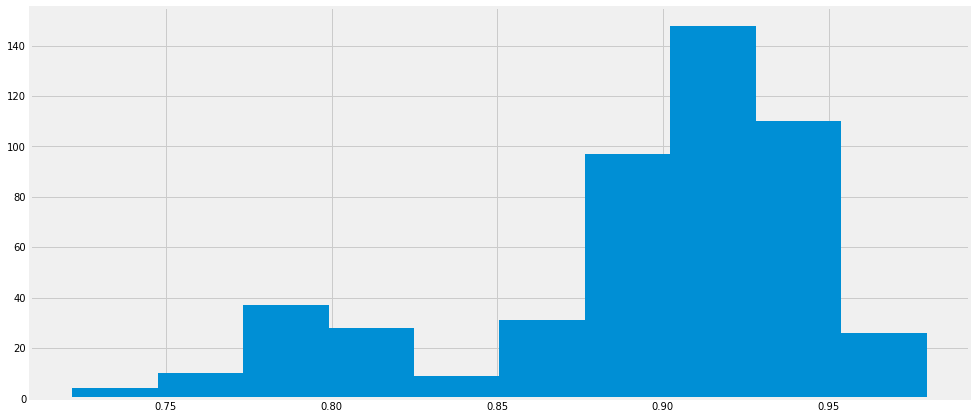

95.0 confidence interval 76.5% and 96.1%


In [89]:
# plot scores
plt.figure(figsize = (15, 7.2))
plt.hist(stats); plt.show()

# confidence intervals
alpha = 0.95 # for 95% confidence 
p = ((1.0 - alpha) / 2.0) * 100 # tail regions on right and left .25 on each side indicated by P value (border)
lower = max(0.0, np.percentile(stats, p))  

p = (alpha + ((1.0 - alpha) / 2.0)) * 100
upper = min(1.0, np.percentile(stats, p))

print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

<a id='conclusion'></a>
### Conclusion
* In the **EDA stage** we explored the use of custom function to view IQR, Kurtosis, Skewness and other statistics and comment on whether the column has outliers or not. Performed further descriptive statistics to explore missing values and outliers. We also checked the relation between independent and dependent variables and observed that for some variables the relationship was linear. Used strategies such as visuals (boxplots), IQR method, studentized residual, leverage, Cook's D and DFFITS to analyze outliers and address leverage points.
* In the **feature engineering stage**, we identified opportunities to add features based on variable interaction and gaussians but ended up adding multicollinearity in the data.
* Used methods such as **model based feature importance, eli5, correlation matrix, absolute correlation and variance inflation factor** to understand important attributes.
* Used **cross validation method** to compare linear and non-linear/tree-based models on training and validation sets. Here it was also important to check and see if there's any improvement after feature engineering. We found a **significant improvement in the R2 scores** (which was chosen as an evaluation criterion for the study) after performing exploratory data analysis and feature engineering steps.
* It was also important to decide on whether to scale the data or not and if it's to be scaled then which method to be used. For this we ran a comparison analysis on both validation and test sets and saw that the results were almost similar.
* <span class="mark">Here we tried **3 linear regressions (Linear, Lasso and Ridge) and decision tree-based regression methods such as Decision Tree, Random Forest, AdaBoost, Gradient Boost and Extra Trees regressor**. We used **k-Fold cross validation, grid search and random search methods** to squeeze out the extra performance from the regressors. For some it resulted an improvement while for some it didn't owing to the limited hyperparameter space. For this specific problem, **Gradient Boost Regressor** turned out to be the best performing model when used with 5-fold cross validation and grid/random search with r2 for **training, validation and test as 0.999, 0.931 and 0.899 respectively**. Additionally, we also explored CatBoost regressor to explore interaction between features and modelling as well. None of the model were seen overfitting. </span>
* Then we also Bootstrapping method to calculate confidence intervals for Gradient Boost Regressor. We found a 95% likelihood of r2 score between 76.5% and 96.1% for Gradient Boost Regressor.

In [90]:
display(df)

r2 Scores Train  r2 Scores Val  \
5-Fold LinearRegression                                 0.7600         0.7504   
5-Fold LassoRegression                                  0.7587         0.7498   
5-Fold RidgeRegression                                  0.7600         0.7504   
5-Fold DecisionTree                                     0.9991         0.8459   
5-Fold DecisionTree GridSearchCV                        0.9991         0.8459   
5-Fold DecisionTree RandomizedSearchCV                  0.9991         0.8459   
5-Fold RandomForest                                     0.9771         0.8858   
5-Fold RandomForest GridSearchCV                        0.9867         0.9039   
5-Fold RandomForest RandomizedSearchCV                  0.9857         0.9001   
5-Fold AdaBoost                                         0.8351         0.7922   
5-Fold AdaBoost using GridSearchCV                      0.9970         0.9071   
5-Fold AdaBoost using RandomizedSearchCV                0.9966         0.9085   
5-Fold GradientBoost                                    0.9564         0.9019   
5-Fold GradientBoost using GridSearchCV                 0.9990         0.9307   
5-Fold GradientBoost using RandomizedSearchCV           0.9990         0.9307   
5-Fold ExtraTrees                                       0.9991         0.8918   
5-Fold ExtraTrees using GridSearchCV                    0.9991         0.9134   
5-Fold ExtraTrees using RandomizedSearchCV              0.9991         0.9135   
5-Fold CatBoost                                         0.9778         0.9284   
5-Fold CatBoost GridSearch                              0.9771         0.9280   
5-Fold CatBoost RandomSearch                            0.9872         0.9228   

                                               r2 Scores Test  
5-Fold LinearRegression                                0.6671  
5-Fold LassoRegression                                 0.6653  
5-Fold RidgeRegression                                 0.6671  
5-Fold DecisionTree                                    0.8014  
5-Fold DecisionTree GridSearchCV                       0.8014  
5-Fold DecisionTree RandomizedSearchCV                 0.8014  
5-Fold RandomForest                                    0.8667  
5-Fold RandomForest GridSearchCV                       0.8776  
5-Fold RandomForest RandomizedSearchCV                 0.8736  
5-Fold AdaBoost                                        0.7504  
5-Fold AdaBoost using GridSearchCV                     0.8658  
5-Fold AdaBoost using RandomizedSearchCV               0.8655  
5-Fold GradientBoost                                   0.8671  
5-Fold GradientBoost using GridSearchCV                0.8994  
5-Fold GradientBoost using RandomizedSearchCV          0.8994  
5-Fold ExtraTrees                                      0.8593  
5-Fold ExtraTrees using GridSearchCV                   0.8759  
5-Fold ExtraTrees using RandomizedSearchCV             0.8761  
5-Fold CatBoost                                        0.8892  
5-Fold CatBoost GridSearch                             0.8859  
5-Fold CatBoost RandomSearch                           0.8834